# Projet de Machine Learning: ECG Heartbeat Classification

# 1. Introduction

Dans ce projet, nous essayons de mettre en pratique nos connaissances en apprentissage statistique pour faire la prévision de la catégorie des battements cardiaques.

   Notre jeu de données est constitué de 87554 electrocardiogrammes échantillonés à la fréquence de 125hz,c’est-à-dire une valeur toutes les 0,008 secondes. On a donc pour chacun des signaux 187 valeurs sur 1,488s. Ils sont répartis sur 5 catégories:
   
   
    -Normal
    Bloc de branche gauche / droite
    Évasion Arial
    Échappement nodal

    -Auriculaire prématuré
    Atrial aberrant prématuré
    Nodal prématuré
    Prématuré supra-ventriculaire

    -Contraction ventriculaire prématurée
    Évacuation ventriculaire

    -Fusion ventriculaire et normale

    -Rythmé
    Fusion du rythme et de la normale
    Inclassable.
    
   Ces classes ou catégories sont recodées préablement et respectivement en 0,1,2,3,et 4.
   



Dans l'article expliquant tout ce processus  [ici](https://arxiv.org/pdf/1805.00794.pdf) nous trouvons la signification suivantes des différents labels ou catégories :


| Category(data)        |  Category(Paper)     | Annotations  |
| ------------- |:-------------:| -----:|
|0|N| <ul><li>Normal</li><li>Left/Right bundle branch block</li><li>Arial escape</li><li>Nodal escape</li></ul>  |
|1|S| <ul><li>Atrial premature</li><li>Aberrant atrial premature</li><li>Nodal premature</li><li>Supra-ventricular premature</li></ul> |
|2|V| <ul><li>Premature ventricular contraction</li><li>Ventricular escape</li></ul> |
|3|F| <ul><li>Fusion of ventricular and normal</li></ul> |
|4|Q| <ul><li>Paced</li><li>Fusion of paced and normal</li><li>Unclassifiable</li></ul> |



Dans ce projet de High Dimensional Learning, nous  travaillerons sur les signaux directement et sur leurs projections dans différentes bases. 

Nous allons dans un premier temps répartir les données en échantillons d'apprentissage et de validation, ensuite rééquilibrer les classes, calculer des coefficients d'ondelettes et de Fourier sur les signaux et faire l'exploration de ces données, puis implémenter nos différents algorithmes de classification, avant de passer à un apprentissage profond sur les signaux directement.

**NOTE: Ce calepin est commenté au fur et à mesure des résultats obtenus.**

# 2. Chargement des Librairies

In [41]:
import pandas as pd
import numpy as np
import random
import itertools
import collections
import time
import utils.load as ul


# Plot et Display
import utils.illustration as uil
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

# Exploration
import sklearn.decomposition as sdec 
import sklearn.preprocessing as sprep
import sklearn.discriminant_analysis as sda

#Prediction
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
import scipy as sc
sb.set_style("whitegrid")
import matplotlib.pyplot as plt
import random
import keras.models as km 
import keras.layers as kl 
import keras.layers.core as klc
from keras import backend as K
import tensorflow as tf
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
CMAP = plt.get_cmap("Set1")
COLOR = [CMAP(k) for k in range(5)]
NAME_DIC = {k:v for k,v in zip([0,1,2,3,4],['N','S','V','F','Q'])}
COLOR_DIC = {v:CMAP(k-1) if v!="N" else CMAP(10) for k,v in NAME_DIC.items()}

# 3. Lecture des données


Dans cette partie, nous chargeons les deux jeux de données d'apprentissage (train) et de validation (test), ici nos signaux et en visualisons quelques à titre illustratif.

Les données d'apprentissage sont presque 13 fois plus volumineux que les données de validation. Ce qui est un point positif et justifie le fait qu'il n'y ait pas de validation croisée Monte Carlo implémentée dans ce calepin.

In [3]:
# Nom des colonnes
Colnames = [str(k) for k in range(187)] + ["label"]

In [4]:
LABELS = [NAME_DIC[c] for c in range(0,5)]

In [5]:
# Train
mitbih_train_0 = pd.read_csv("mitbih_train.csv.zip", header=None, names=Colnames)
N_train = mitbih_train_0.shape[0]
print(mitbih_train_0.shape)
mitbih_train_0.head(5)

(87554, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Test
mitbih_test_0 = pd.read_csv("mitbih_test.csv", header=None, names = Colnames)
N_test = mitbih_test_0.shape[0]
print(mitbih_test_0.shape)
mitbih_test_0.head(5)

(6774, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.758982,0.473054,0.193114,0.142216,0.176647,0.161677,0.142216,0.121257,0.107784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.746556,0.088154,0.035813,0.212121,0.253444,0.269972,0.283747,0.275482,0.272727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.972840,0.728395,0.000000,0.037037,0.162963,0.143210,0.123457,0.140741,0.133333,0.096296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.694444,0.238095,0.321429,0.337302,0.337302,0.301587,0.325397,0.325397,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.939815,0.791667,0.199074,0.000000,0.055556,0.101852,0.106481,0.143519,0.222222,0.189815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
mitbih_train_0=mitbih_train_0.sort_values(by='label')
mitbih_test_0=mitbih_test_0.sort_values(by='label')

In [8]:
import collections
collections.Counter(mitbih_test_0.label)

Counter({0.0: 3000, 1.0: 556, 2.0: 1448, 3.0: 162, 4.0: 1608})

## 3.1 Illustration 

### 3.1.1 Un signal

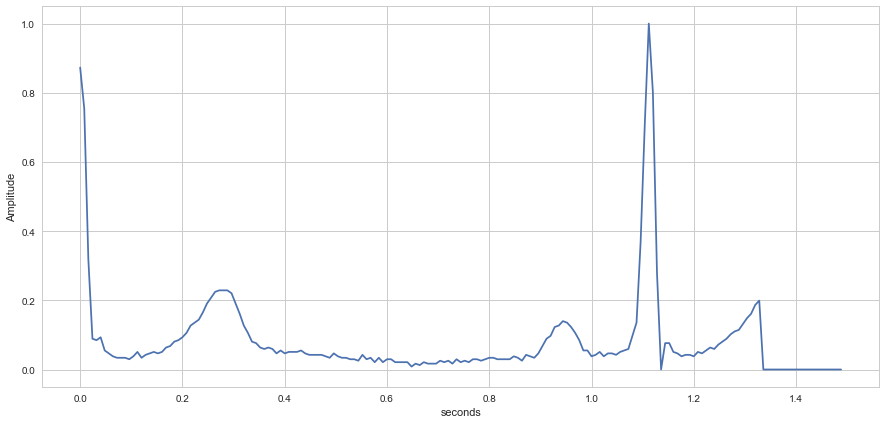

In [9]:
xsec = np.arange(187)*0.008

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,mitbih_train_0.values[1,:-1])
ax.set_xlabel("seconds")
ax.set_ylabel("Amplitude")
plt.show()

### 3.1.2 Dix premiers signaux pour chaque groupe

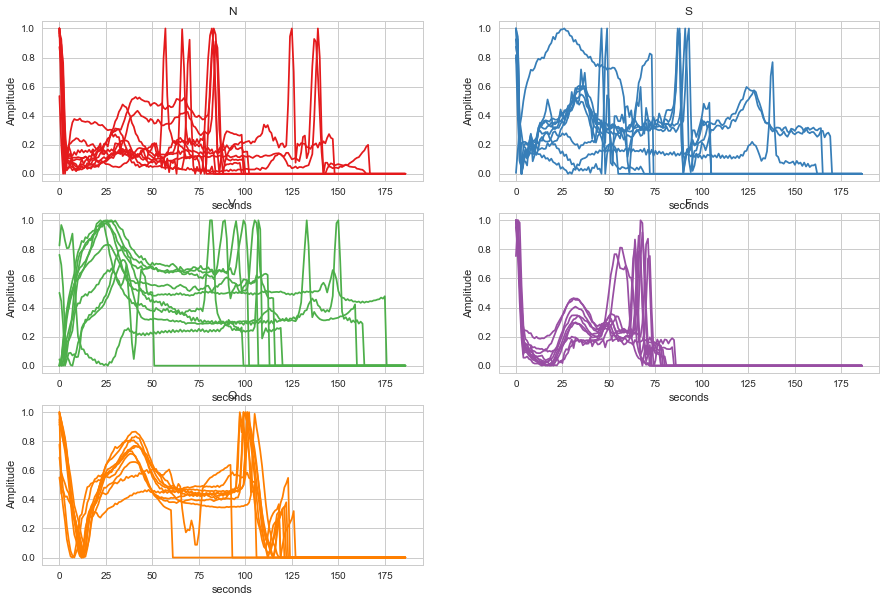

In [10]:
fig = plt.figure(figsize=(15,10))
for i,(k,v) in enumerate(mitbih_train_0.groupby("label")):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(v.values[:10,:-1].T, color=COLOR[int(k)])
    ax.set_title(NAME_DIC[k])
    ax.set_xlabel("seconds")
    ax.set_ylabel("Amplitude")
plt.show()

# **COMMENTAIRE** : 
Les représentations ci-dessus nous permettent de nous familiariser avec les signaux, les électrocardiogrammes qui  sont nos données d'étude, ainsi que les catégories de battements cardiaques à notre disposition.

## 3.2 Répartition des catégories

Ici, nous répartissons les signaux des échantillons d'apprentissage et de validation dans les différentes catégories précédemment identifiées. 

### 3.2.1 Echontillon de test

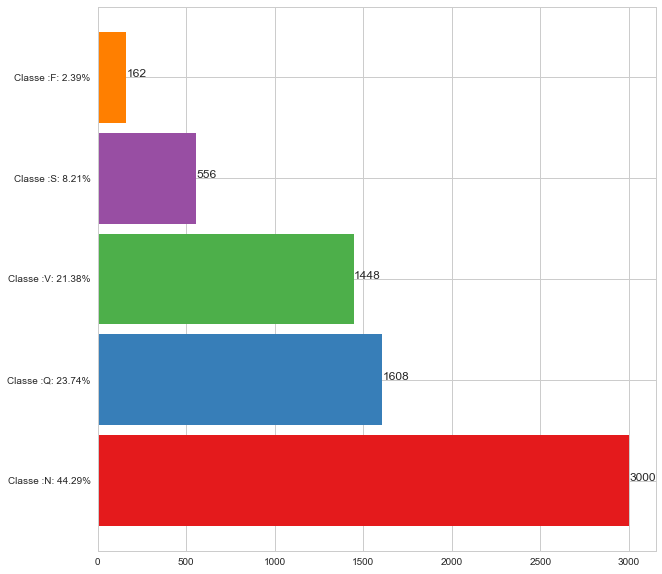

In [11]:
data_count = mitbih_test_0.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_test) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))
plt.show()


### 3.2.2 Echantillon d'apprentissage

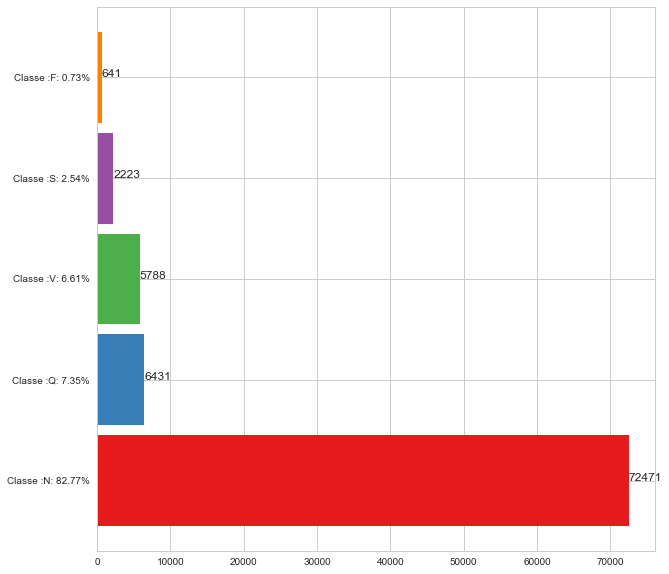

In [12]:
data_count = mitbih_train_0.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))

plt.show()

# **COMMENTAIRE** : 
Les données sont fortement déséquilibrées. Particulièrement la classe "F" qui ne possèdent que 641 éléments (0.73%) dans l'apprentissage et la classe "N" qui est plus de 7 (82.77%) fois plus important que toutes les autres catégories.

Pour corriger cela, nous allons procéder à une augmentation de certaines classes et à  une réduction de la classe "N" afin de réequilibrer les classes aussi bien des données d'apprentissage que de validation.




# 4. Méthode d'augmentation des données
Pour augmenter les données, on peut pocéder à :
    * de l'oversampling, en dupliquant certaines séries (Amplify) 
    * de l'augmentation de données, en créant de nouveaux signaux par déformation des signaux existant (Stretch).
   
 En utilisant une de ces deux fonctions, ou en combinant les deux, il est alors possible de créer de nouveau signaux.


## 4.1 Amplify

Cette méthode permet d'amplifier le signal suivant la formule suivante : 

new_x =  $-\alpha\cdot x^2 + -\alpha\cdot x^2 + x$ avec $-0.5<\alpha<0.5$

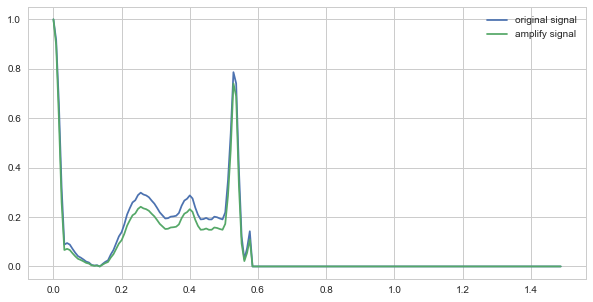

In [13]:
def amplify(x,alpha):
    coef = (alpha-0.5)
    factor = -coef*x + (1+coef)
    return x*factor

x_toy = mitbih_train_0.groupby("label").get_group(3).values[0,:-1]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,x_toy, label = 'original signal')
ax.plot(xsec,amplify(x_toy,np.random.rand()), label = 'amplify signal')
plt.legend()


## 4.2 Stretch

Cette méthode étire ou "compresse" le signal. Cette étape est effectué grâce à la fonction *resample* du package *scipy.signal* qui permet de ré-echantilloner un signal à l'aide d'une transformée de Fourier.

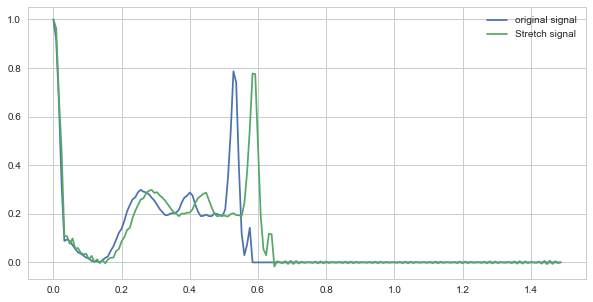

In [14]:
from scipy.signal import resample
def stretch(x,alpha):
    l = int(187 * (1 + (alpha-0.5)/3))
    y = sc.signal.resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(xsec,x_toy, label = 'original signal')
ax.plot(xsec,stretch(x_toy,np.random.rand()), label = 'Stretch signal')
plt.legend()

# 5. Réequilibrage des classes

Nous nous aidons des deux méthodes, détaillées plus haut, d'augmentation des données pour générer de nouveaux signaux pour les classes les moins représentées et tout simplement équilibrer les classes de nos deux jeux de données. 

Pour la classe sur-représentée, nous allons garder que 10% de ces données. 

Les codes suivants détaillent les différentes étapes qui sont commentées au fur et à mesure pour faciliter la compréhension.

In [15]:
#Regroupement de chaque catégorie de l'échantillon Train
class0_train=mitbih_train_0.loc[mitbih_train_0.label == 0]
class1_train=mitbih_train_0.loc[mitbih_train_0.label == 1]
class2_train=mitbih_train_0.loc[mitbih_train_0.label == 2]
class3_train=mitbih_train_0.loc[mitbih_train_0.label == 3]
class4_train=mitbih_train_0.loc[mitbih_train_0.label == 4]

#Regroupement de chaque catégorie de l'échantillon Test
class0_test=mitbih_test_0.loc[mitbih_test_0.label == 0]
class1_test=mitbih_test_0.loc[mitbih_test_0.label == 1]
class2_test=mitbih_test_0.loc[mitbih_test_0.label == 2]
class3_test=mitbih_test_0.loc[mitbih_test_0.label == 3]
class4_test=mitbih_test_0.loc[mitbih_test_0.label == 4]

In [16]:
#Regroupement des valeurs de chaque catégorie de l'échantillon Train
X_train0=class0_train.values[:,:]
X_train1=class1_train.values[:,:]
X_train2=class2_train.values[:,:]
X_train3=class3_train.values[:,:]
X_train4=class4_train.values[:,:]

#Regroupement des valeurs de chaque catégorie de l'échantillon Train
X_test0=class0_test.values[:,:]
X_test1=class1_test.values[:,:]
X_test2=class2_test.values[:,:]
X_test3=class3_test.values[:,:]
X_test4=class4_test.values[:,:]


In [17]:
#Nombre de signaux à augmenter ou diminuer de chaque catégorie des deux échantillons 
N0_train=65000 # -65000
N1_train=3000
N3_train=7*641

N1_test=600
N3_test=7*162

In [18]:
### la position de la classe N à partir de laquelle on effectue une suppression des données
np.random.seed(11)
arr_train0=random.sample(range(X_train0.shape[0]),N0_train)

### Coefficient alpha pour les fontions d'augmentation des données
np.random.seed(111)   
arr_train1=np.random.rand(N1_train)
arr_train3=np.random.rand(N3_train)

arr_test1=np.random.rand(N1_test)
arr_test3=np.random.rand(N3_test)

In [19]:
### suppression de  65000 individus dans la classe N de l'échantillon d' apprentissage
X_train0=np.delete(X_train0,arr_train0,axis=0)

In [20]:
## Génération de  N1_train individus dans X1 par amplify et stretch
add_train1=np.zeros((N1_train,188))
add_train1[:,187]=1
for i in range(int(N1_train/2)):
    add_train1[i,:-1]=amplify(X_train1[i,:-1],arr_train1[i])
    add_train1[i+1500,:-1]=stretch(X_train1[-i,:-1],arr_train1[i+1500])

In [21]:
X_train1=np.concatenate((add_train1,X_train1),axis=0)#Concaténation avec les signaux précédents
X_train1.shape

(5223, 188)

In [22]:
## Génération de  N3_train individus dans X3 par amplify et stretch
n=641
add_train3=np.zeros((N3_train,188))
add_train3[:,187]=3
for i in range(n):
    add_train3[i,:-1]=amplify(X_train3[i,:-1],arr_train3[i])
    add_train3[i+n,:-1]=stretch(X_train3[i,:-1],arr_train3[i+n])
    add_train3[i+n*2,:-1]=amplify(X_train3[i,:-1],arr_train3[i+n*2])
    add_train3[i+n*3,:-1]=stretch(X_train3[i,:-1],arr_train3[i+n*3])
    add_train3[i+n*4,:-1]=amplify(X_train3[i,:-1],arr_train3[i+n*4])
    add_train3[i+n*5,:-1]=stretch(X_train3[i,:-1],arr_train3[i+n*5])
    add_train3[i+n*6,:-1]=stretch(X_train3[i,:-1],arr_train3[i+n*6])
 

In [23]:
X_train3=np.concatenate((add_train3,X_train3),axis=0)#Concaténation avec les signaux précédents
X_train3.shape

(5128, 188)

In [24]:
## Génération de N1_test individus dans X1 par amplify et stretch
add_test1=np.zeros((N1_test,188))
add_test1[:,187]=1
for i in range(int(N1_test/2)):
    add_test1[i,:-1]=amplify(X_test1[i,:-1],arr_test1[i])
    add_test1[i+int(N1_test/2),:-1]=stretch(X_test1[-i,:-1],arr_test1[i+int(N1_test/2)])

In [25]:
X_test1=np.concatenate((add_test1,X_test1),axis=0)#Concaténation avec les signaux précédents
X_test1.shape

(1156, 188)

In [26]:
## Génération de N1_test et N3_test individus dans X3 par amplify et stretch
n=162
add_test3=np.zeros((N3_test,188))
add_test3[:,187]=3
for i in range(n):
    add_test3[i,:-1]=amplify(X_test3[i,:-1],arr_test3[i])
    add_test3[i+n,:-1]=stretch(X_test3[i,:-1],arr_test3[i+n])
    add_test3[i+n*2,:-1]=amplify(X_test3[i,:-1],arr_test3[i+n*2])
    add_test3[i+n*3,:-1]=stretch(X_test3[i,:-1],arr_test3[i+n*3])
    add_test3[i+n*4,:-1]=amplify(X_test3[i,:-1],arr_test3[i+n*4])
    add_test3[i+n*5,:-1]=stretch(X_test3[i,:-1],arr_test3[i+n*5])
    add_test3[i+n*6,:-1]=amplify(X_test3[i,:-1],arr_test3[i+n*6])

In [27]:
X_test3=np.concatenate((add_test3,X_test3),axis=0)#Concaténation avec les signaux précédents
X_test3.shape

(1296, 188)

In [28]:
#Concaténation de tous les vecteurs pour reconstituer l'échantillon d'apprentissage et celui de test avec des classes équilibrées
mitbih_train=pd.DataFrame(np.concatenate((X_train0,X_train1,X_train2,X_train3,X_train4),axis=0))
mitbih_test=pd.DataFrame(np.concatenate((X_test0,X_test1,X_test2,X_test3,X_test4),axis=0))

mitbih_train.columns=Colnames
mitbih_test.columns=Colnames

N_train = mitbih_train.shape[0]

# 6. Visualisation des données après réequilibrage des classes

## 6.1 Echantillon de test

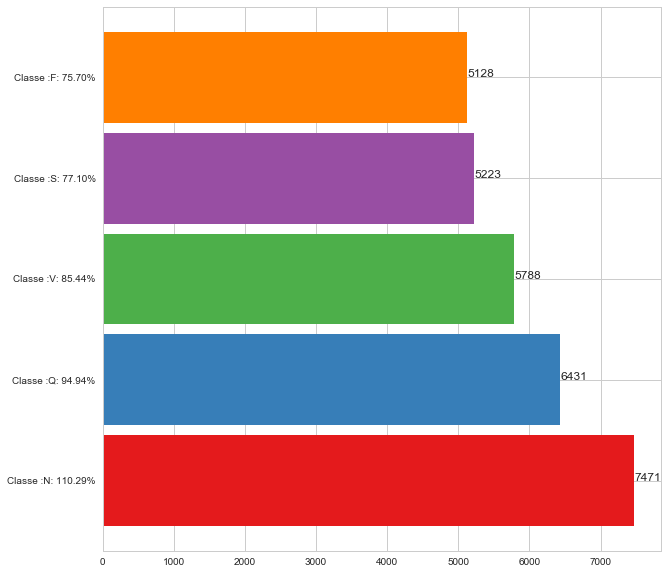

In [29]:
data_count = mitbih_train.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_test) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))
plt.show()

## 6.2 Echantillon d'apprentissage

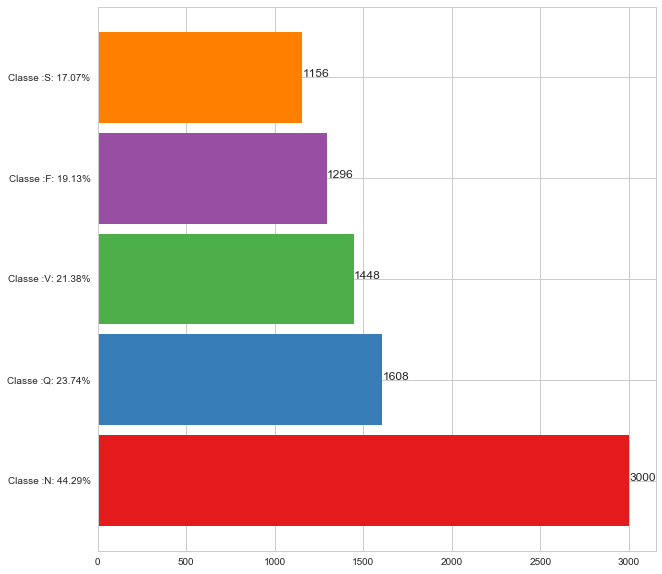

In [30]:
data_count = mitbih_test.label.astype(int).value_counts()
#Rename index to add percentage
new_index = ["Classe :" + NAME_DIC[k]+ ": %.2f%%" %(v*100/N_test) for k,v in data_count.iteritems()]

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.barh(range(5), data_count.values, 0.9, color = COLOR, tick_label = new_index)
for k in range(5):
    ax.text(data_count.values[k], k, str(data_count.values[k]))
plt.show()

Les classes ainsi réequilibrées, nous pouvons passer à la création des features.

In [31]:
# Suppression de la colonne label
X_train = mitbih_train.values[:,:-1]
Y_train = mitbih_train.values[:,-1]

X_test = mitbih_test.values[:,:-1]
Y_test = mitbih_test.values[:,-1]

In [32]:
mitbih_test.to_csv("test/test.csv",sep=',',index=False,header=False)
mitbih_train.to_csv("train/train.csv",sep=',',index=False,header=False)

### ACP

Nous faisons ici une description multivariée des signaux d'apprentissage par une Analyse en Composantes Principales.

In [34]:
N_train = mitbih_train.shape[0]
N_test = mitbih_test.shape[0]

In [35]:
def plot_variance_acp(fig, acp, X_acp, whis=1.5): 
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("", fontsize=35)
    ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)
    
    ax = fig.add_subplot(1,2,2)
    box=ax.boxplot(X_acp[:,0:10], whis=whis)
    ax.set_title("Distribution des premieres composantes", fontsize=20)
    
def plot_pca(ax, X, acp, nbc, nbc2, colors, markersizes):
    ax.scatter(X[:,nbc-1],X[:,nbc2-1],marker=".", color= colors, s=markersizes)
    ax.set_xlabel("PC%d : %.2f %%" %(nbc,acp.explained_variance_ratio_[nbc-1]*100), fontsize=15)
    ax.set_ylabel("PC%d : %.2f %%" %(nbc2,acp.explained_variance_ratio_[nbc2-1]*100), fontsize=15)


In [36]:
import sklearn.decomposition as sdec 
pca = sdec.PCA()
X_r = pca.fit_transform(X_train)

Text(0.5,0.98,'Résultat ACP')

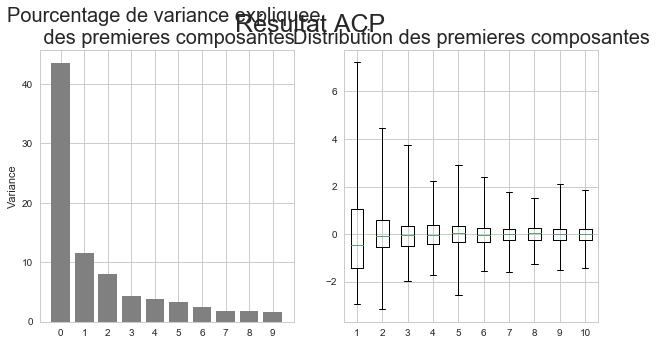

In [37]:
fig = plt.figure(figsize=(10,5))
plot_variance_acp(fig, pca, X_r, whis=100)
fig.suptitle("Résultat ACP", fontsize=25)

Représentation de la décroissance des valeurs propres, les variances des variables ou composantes principales (à gauche) et un graphique plus explicite décrit les distributions de ces composantes par des diagrammes boîtes; seules les premières sont affichées (à droite).

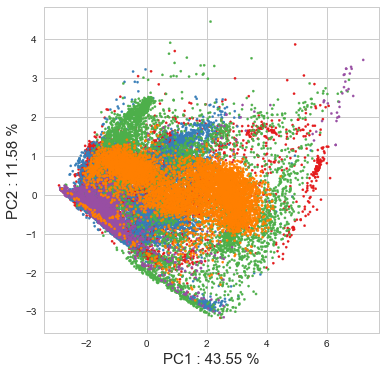

In [38]:
colors=[COLOR[int(y)] for y in mitbih_train.values[:,-1]]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(6,6), )
ax = fig.add_subplot(1,1,1)
plot_pca(ax,X_r, pca, 1, 2, colors, markersizes)

# **COMMENTAIRE** : 
Les deux premiers axes expliquent presque 70% de la variance des données. Mais hélas, cette représentation des individus est illisible et est donnée à titre informatif.

Toutefois, nous remarquons des formes allongées et allignées de groupes d'individus, ceci peut s'expliquer par les amplifications et stretchings effectués précédemment pour augmenter nos classes d'individus.

### AFD

De même, comme notre variable à prédire est qualitative, nous implémentons une analyse factorielle discriminante .

In [39]:
import sklearn.discriminant_analysis as sda
method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(X_train,Y_train)
X_r2=lda.transform(X_train)

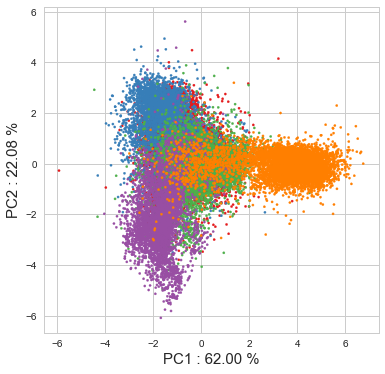

In [40]:
colors=[COLOR[int(y)] for y in mitbih_train.values[:,-1]]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(6,6), )
ax = fig.add_subplot(1,1,1)
plot_pca(ax,X_r2, lda, 1, 2, colors, markersizes)

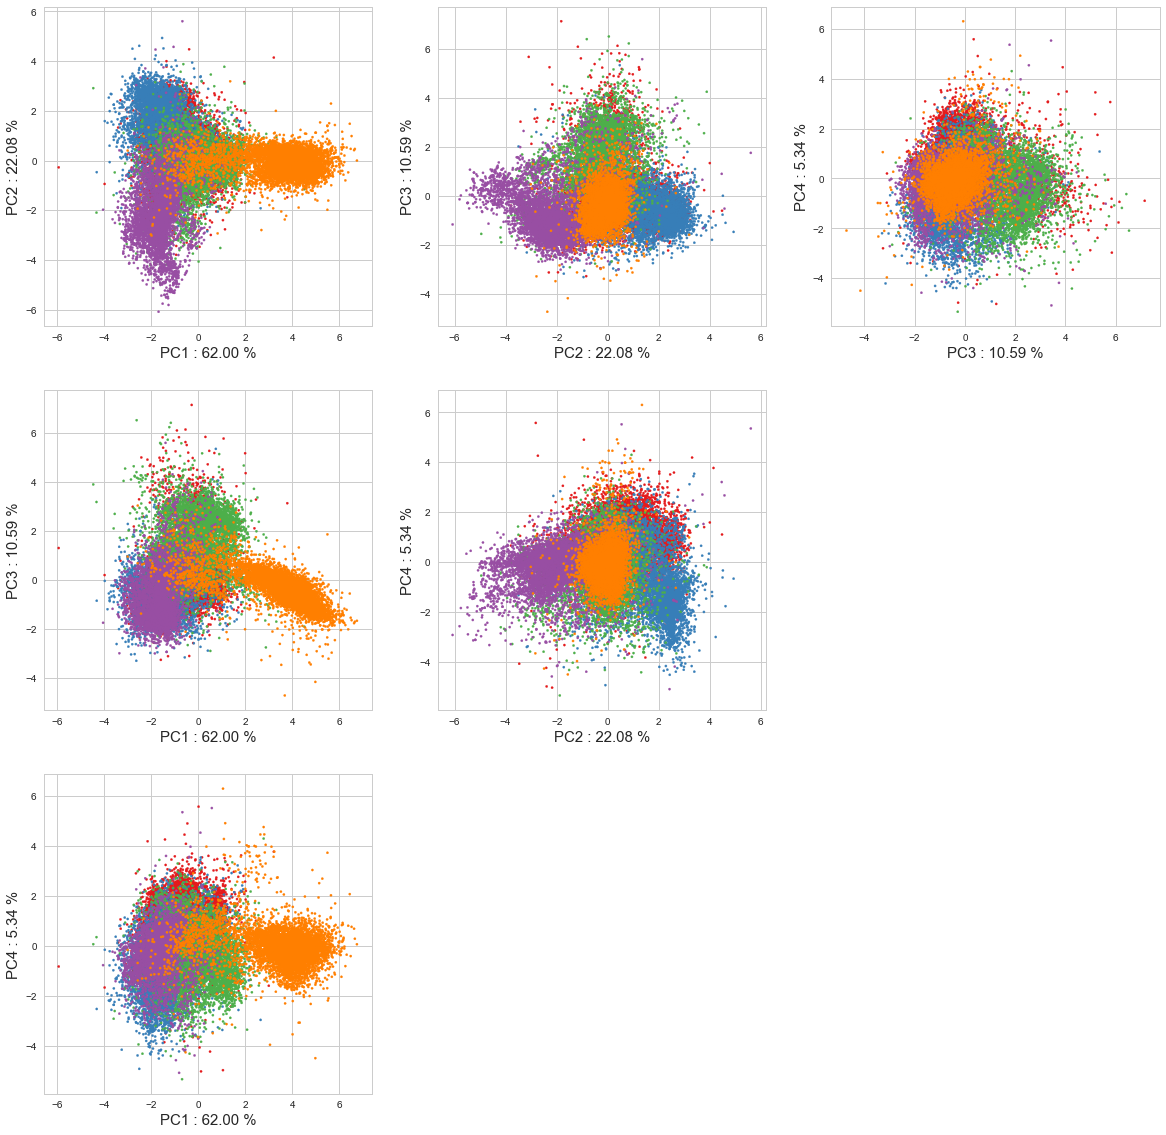

In [41]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_r2, lda, nbc, nbc2, colors, markersizes)
plt.show()

# **COMMENTAIRE** : 
Nous remarquons que les catégories sont mélangées hormis quelques individus ou outliers qui se détachent.
La représentation des individus est également donnée à titre informatif. 



# 7. Calcul des coefficients

Pour ces signaux ou courbes, une métrique euclidienne classique L² est inopérante car les signaux sont trop irréguliers et qu'on observe des pics. C'est pourquoi nous décomposons les signaux dans le domaine des fréquences pour pouvoir récupérer les informations même au niveau des pics.

Calculons donc les coefficients d'ondelettes et ceux de Fourier. 

## 7.1 Calcul des coefficients d'ondelettes

Ici, nous calculons les coefficients d'ondelettes dans la base de Haar(correspondant aussi à la base de Daubeuchies 1) sur l'échantillon d'apprentissage.

In [42]:
import pywt
from pywt import wavedec


## Illustration des coefficients

### Coefficients pour un signal par comportement

In [43]:
Y_train.shape

(30041,)

In [44]:
sample_to_plot = 1
index_per_act_dict = dict([(act, np.where(Y_train==act)[0][:sample_to_plot]) for act in range(0,5)])

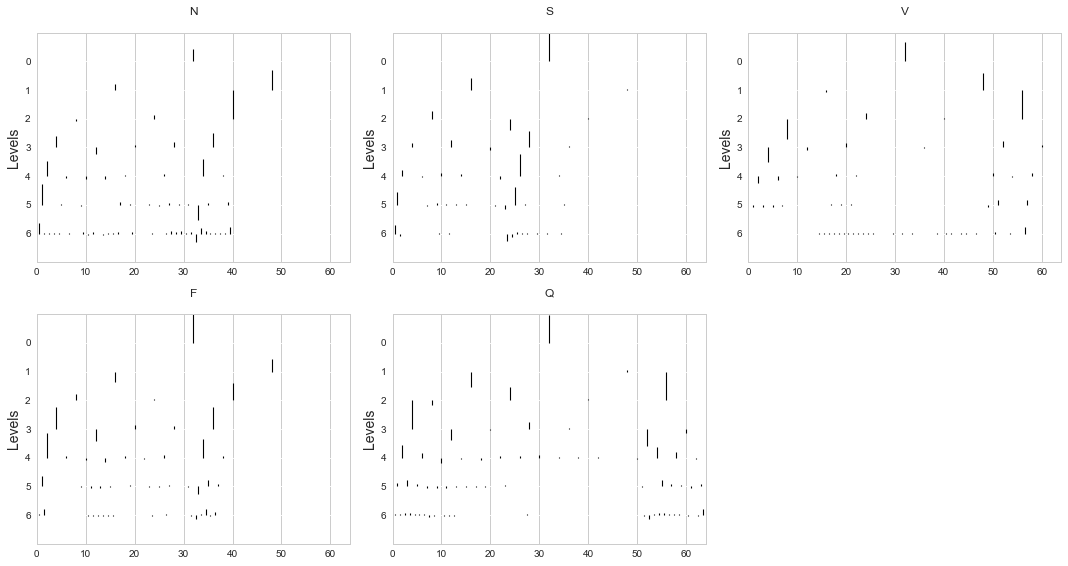

In [47]:
fig = plt.figure(figsize=(15,8))
for ip, (act , index) in enumerate(index_per_act_dict.items()):
    ax=fig.add_subplot(2,3,ip+1)
    coef = pywt.wavedec(X_train[index,:1024], 'db1')
    uil.coef_pyramid_plot(ax, coef[1:]) ;

    ax.set_title(NAME_DIC[act]);
fig.tight_layout()
plt.show()

# **COMMENTAIRE** : 
Les coefficients de normalisation de la fonction d'echelle (phi) et de l'ondelette (psi) de la base de Haar forment une matrice orthogonal et des vecteurs orthonormés.


Sur la figure ci-dessus, nous avons le graphe de ces coefficients jusqu'au niveau le plus fin en fonction des 5 classes de battement cardiaque. Au niveau 0 , on a le coefficient $\alpha$ d'ondelette et sur les niveau suivant nous avons les coefficient $\beta_i$ de la fonction d'échelle. 


On observe plusieurs pics sur le niveau le plus fin (niveau 6), ce qui implique qu'on fera du seuillage(Tresholding) car ces informations ne sont pas prises en compte si on met à 0 ces coefficients d'approximations. En effet, le seuillage permettrait de récupérer ces informations.


## 7.2 Calcul des coefficients de Fourier

Dans cette partie, nous calculons les coefficients de Fourier sur les échantillons test et d'apprentissage.

In [ ]:
X_train_fourier=np.abs(np.fft.fft(X_train,norm='ortho'))
X_test_fourier=np.abs(np.fft.fft(X_test,norm='ortho'))

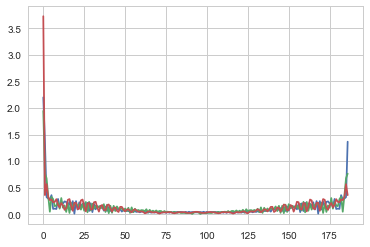

In [49]:
plt.plot(X_train_fourier[1,:])
plt.plot(X_train_fourier[5,:])
plt.plot(X_train_fourier[7,:])
plt.show()

In [50]:
X_train_fourier=X_train_fourier[:,:96]
X_test_fourier=X_test_fourier[:,:96]


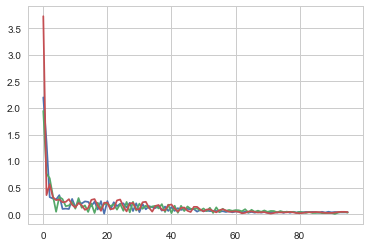

In [51]:
plt.plot(X_train_fourier[1,:])
plt.plot(X_train_fourier[5,:])
plt.plot(X_train_fourier[7,:])
plt.show()

# **COMMENTAIRE** : 

Sur le graphe ci-dessus représentant les coefficients de Fourier, nous constatons une symétrie de part et d'autres de la valeur 96. C'est pourquoi, nous allons travaillé qu'avec une partie des coefficients, ceux entre 0 et 96. 

# 8. Exploration des coefficients

Dans cette section, nous allons procédé à des représentations de type boxplot et celles liées aux ACP sur les coefficients pour nous familiariser avec les données.

## 8.1 Exploration des coefficients d'ondelettes

Sur les coefficients d'ondelettes, nous procéderons toujours sur tous les coefficients ensuite sur les coefficients seuillés.

### Boxplot des coefficients par niveau

In [52]:
N_per_train = collections.Counter(Y_train)
N_per_test = collections.Counter(Y_test)

In [53]:
def plot_boxplot_coef_concat_per_signal(X, Y, labels, activity_dic, color_dic, N_per_activity_train):
    N_level = len(X)
    height = 4*N_level
    fig = plt.figure(figsize=(12,height))
    for i_level in range(N_level):
        ax=fig.add_subplot(N_level,1,i_level+1)
        X_level = X[i_level]
        N_dim = X_level.shape[1]
        for i_act in range(0,5):
            label = activity_dic[i_act]
            color = color_dic[label]
            N_act = N_per_activity_train[i_act]
            X_i_act = X_level[Y==i_act].reshape((N_act*N_dim,1))
            bplot = ax.boxplot(X_i_act, patch_artist=True, positions=[i_act+1])
            bplot["boxes"][0].set_facecolor(color)
            bplot["medians"][0].set_color("black")
            bplot["medians"][0].set_linewidth(2)
        ax.set_xlim(0.5,5.5)
        ax.set_xticks(range(1,6))
        xticks_label = labels if i_level==N_level-1 else ['']*6
        ax.set_xticklabels(xticks_label, rotation=0, fontsize=12)
        ax.set_title("Level : %d" %i_level)

In [54]:
N_per_train

Counter({0.0: 7471, 1.0: 5223, 2.0: 5788, 3.0: 5128, 4.0: 6431})

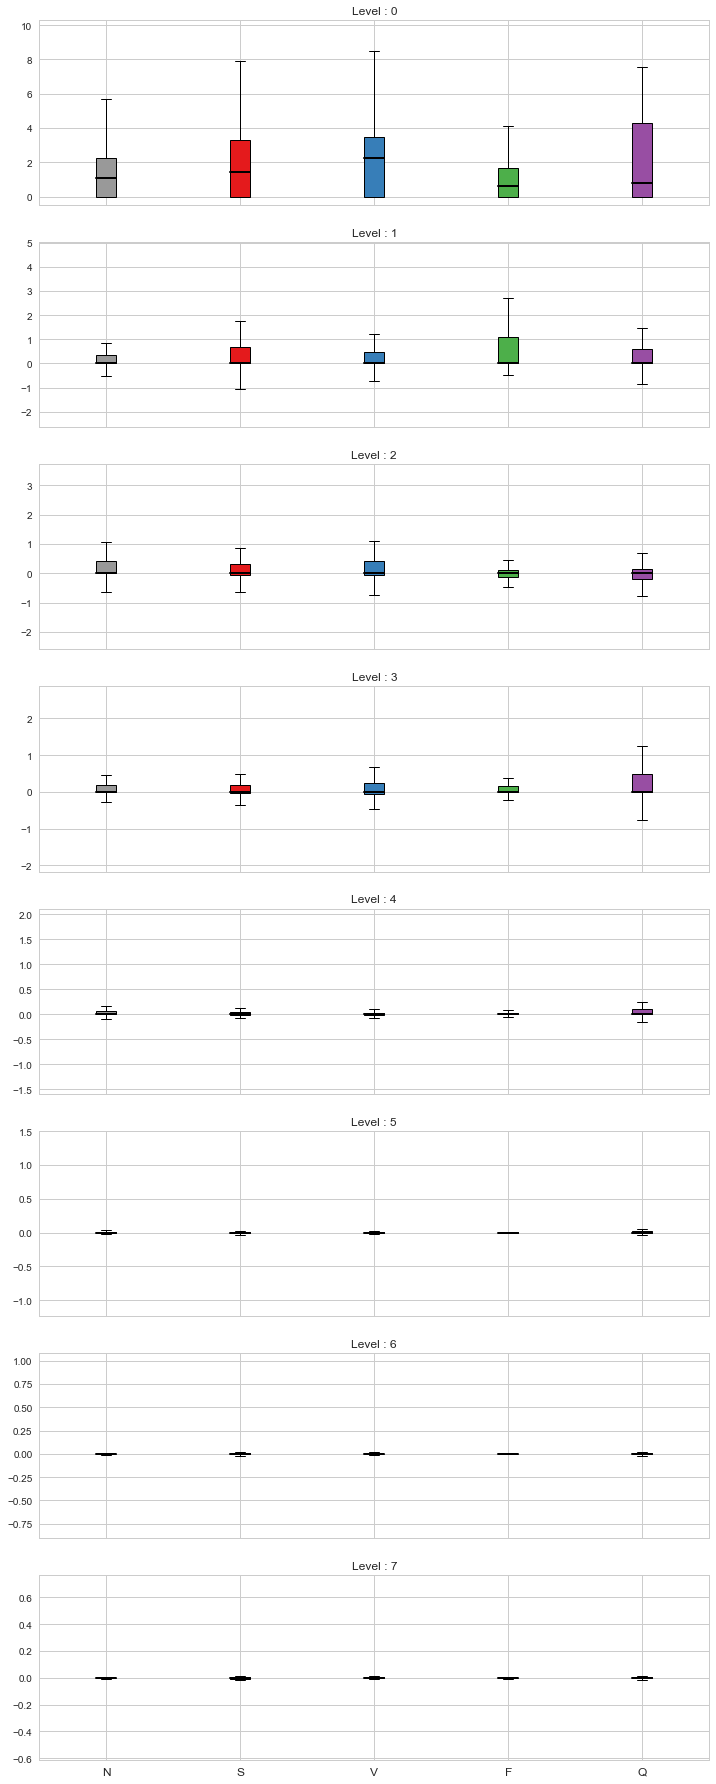

In [55]:
X_train_db_list = pywt.wavedec(X_train, 'db1')
plot_boxplot_coef_concat_per_signal(X_train_db_list, Y_train, labels=LABELS, activity_dic=NAME_DIC, 
                             color_dic=COLOR_DIC, N_per_activity_train= N_per_train)

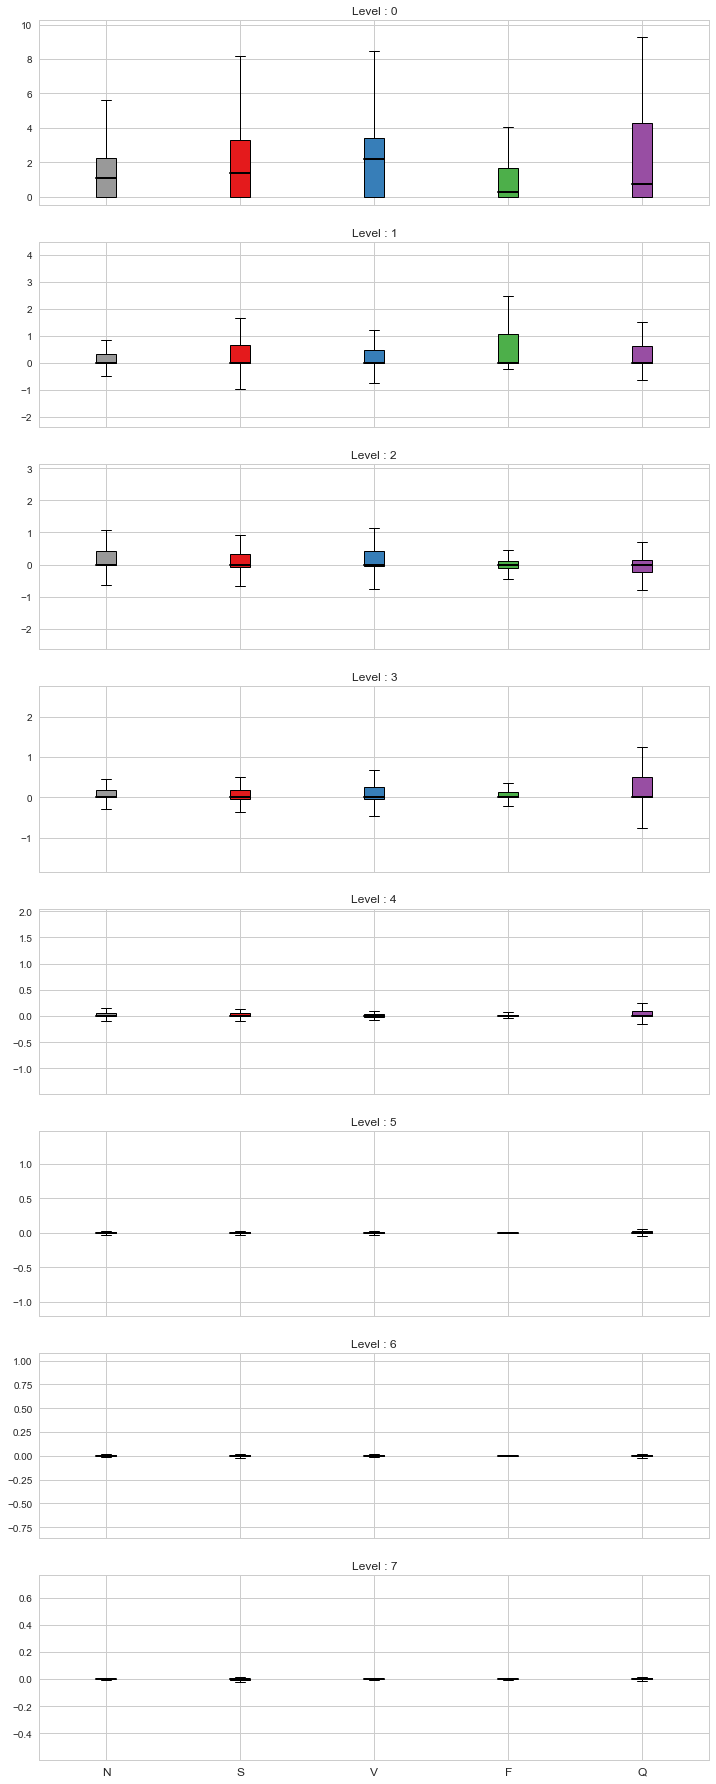

In [56]:
X_test_db_list = pywt.wavedec(X_test, 'db1')
plot_boxplot_coef_concat_per_signal(X_test_db_list, Y_test, labels=LABELS, activity_dic=NAME_DIC, 
                             color_dic=COLOR_DIC, N_per_activity_train= N_per_test)

# **COMMENTAIRE** : 
Ces boxplots sont tracés sur l'échantillon test et sur l'échantillon d'apprentissage séparément et suivant les 5 classes toujours.

Sur les deux jeux de données, les boxplots ne présentent pas de valeurs atypiques et la distribution des signaux est visible jusqu'au niveau 3. Au dela de ce niveau, les boxplots ne sont plus lisible et presque nuls jusqu'au niveau le plus fin, le niveau 6.


La distribution des signaux suivant les 5 classes est cohérente avec l'exploration des données faite au tout début de cette étude.



## ACP sur les coefficients d'ondelettes

### Avec tous les coefficients

In [57]:
X_train_db = np.concatenate(pywt.wavedec(X_train, 'db1'), axis=1)
X_test_db = np.concatenate(pywt.wavedec(X_test, 'db1'), axis=1)

## ACP 
pca = sdec.PCA()
X_train_db_pca = pca.fit_transform(X_train_db)

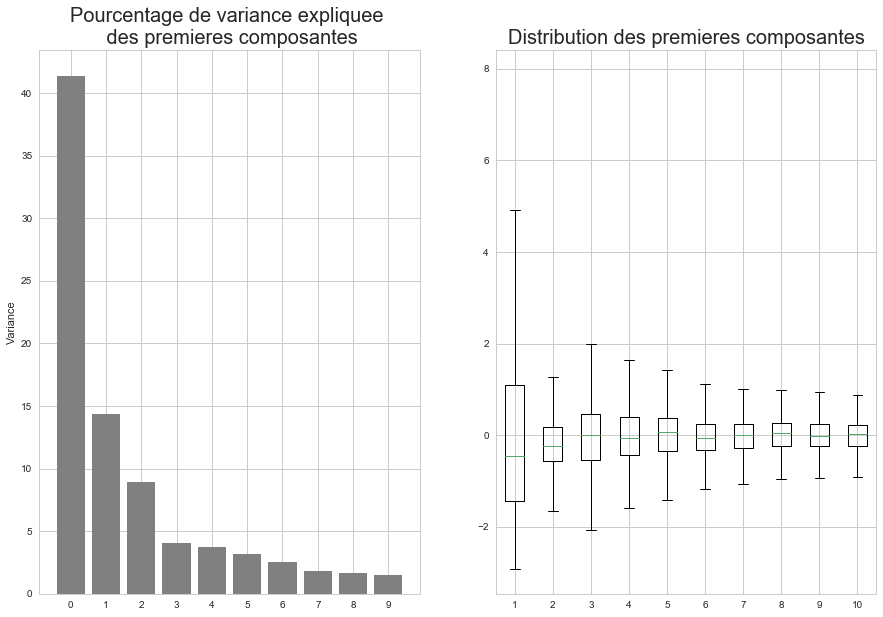

In [58]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_train_db_pca)

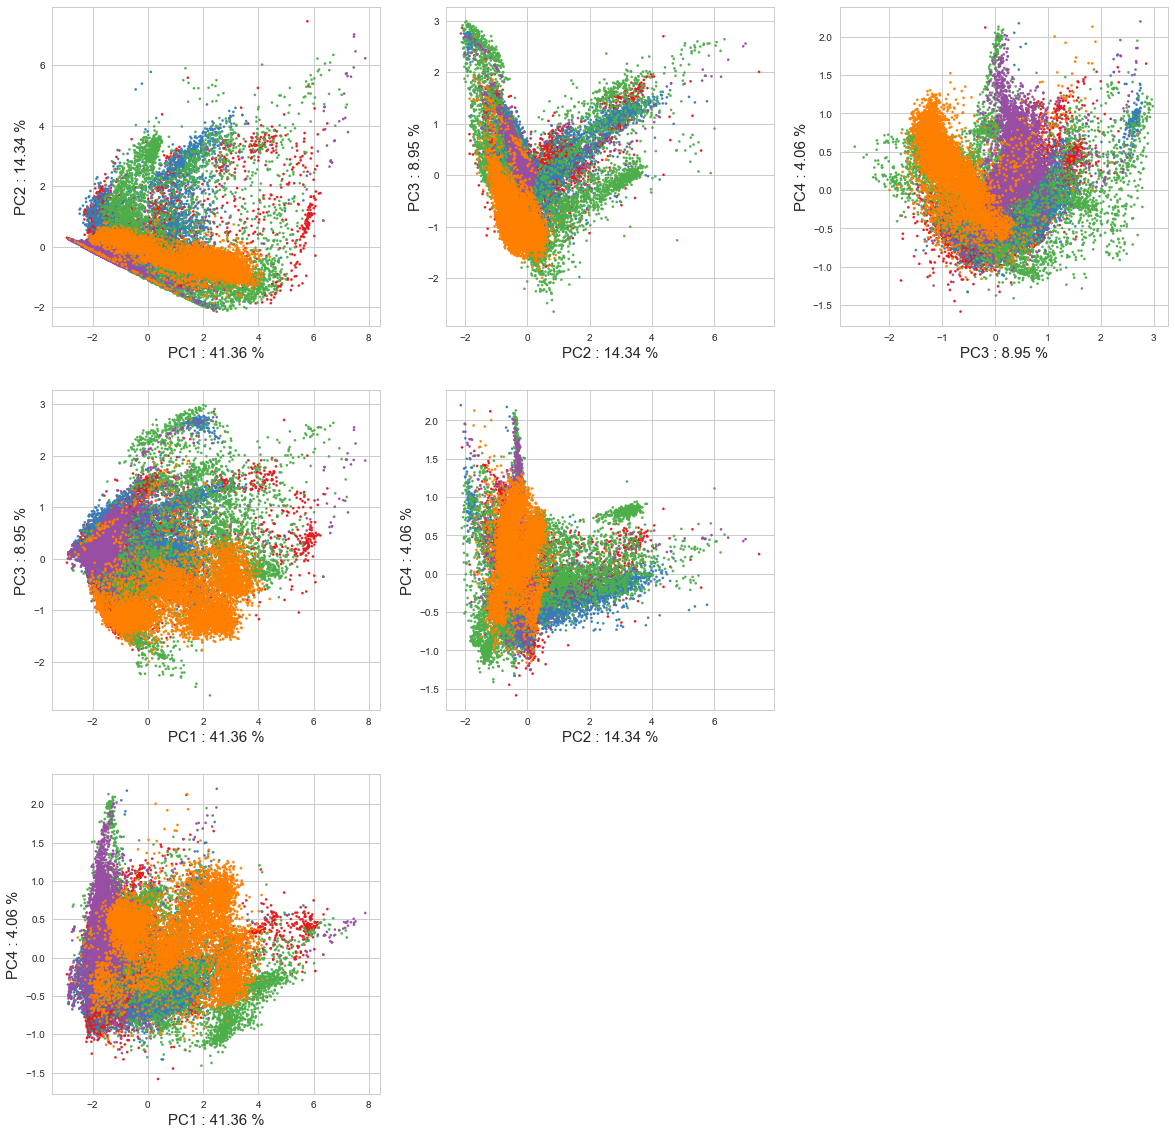

In [59]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_db_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

### Avec les coefficients seuillés

In [60]:
len(pywt.wavedec(X_train, 'db1'))

8

In [61]:
cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(X_train, 'db1')

sigma=0.01
thresh = sigma*np.sqrt(2*np.log((X_train.shape[1])))

# On seuille seulement les coefficients de détail : 

cD7=pywt.threshold(cD7, thresh, 'soft')
cD6=pywt.threshold(cD6, thresh, 'soft')
cD5=pywt.threshold(cD5, thresh, 'soft')
cD4=pywt.threshold(cD4, thresh, 'soft')
cD3=pywt.threshold(cD3, thresh, 'soft')
cD2=pywt.threshold(cD2, thresh, 'soft')
cD1=pywt.threshold(cD1, thresh, 'soft')

X_train_dbth = np.concatenate((cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1), axis=1)

In [62]:
cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(X_test, 'db1')

sigma=0.01
thresh = sigma*np.sqrt(2*np.log((X_test.shape[1])))

# On seuille seulement les coefficients de détail : 
cD7=pywt.threshold(cD7, thresh, 'soft')
cD6=pywt.threshold(cD6, thresh, 'soft')
cD5=pywt.threshold(cD5, thresh, 'soft')
cD4=pywt.threshold(cD4, thresh, 'soft')
cD3=pywt.threshold(cD3, thresh, 'soft')
cD2=pywt.threshold(cD2, thresh, 'soft')
cD1=pywt.threshold(cD1, thresh, 'soft')

X_test_dbth = np.concatenate((cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1), axis=1)

In [63]:
## ACP 
pca = sdec.PCA()
X_train_dbth_pca = pca.fit_transform(X_train_dbth)

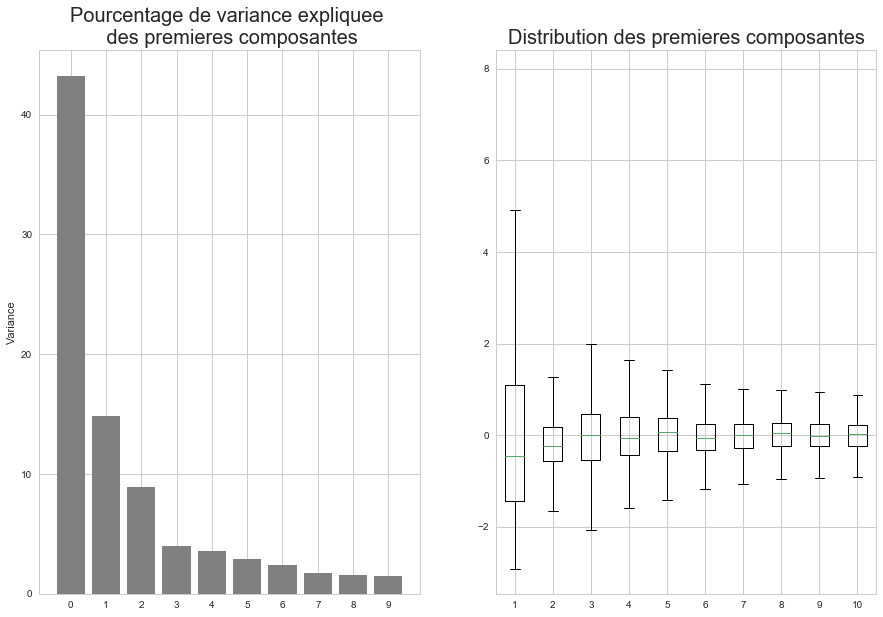

In [64]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_train_db_pca)

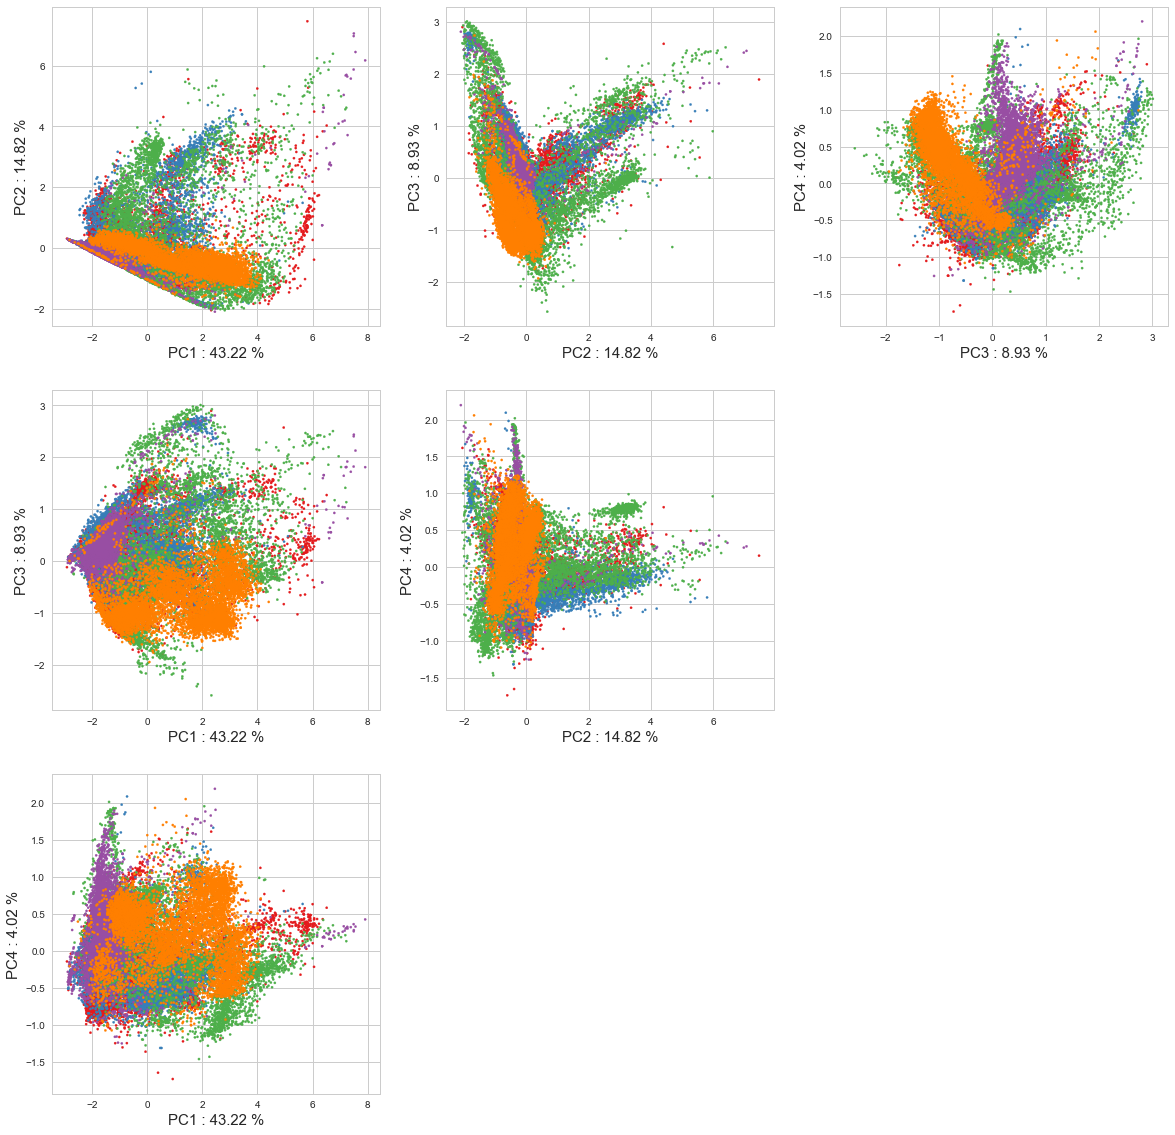

In [65]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_dbth_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

# **COMMENTAIRE** : 
Les différences ne sont pas significatives entre les coefficients et ceux seuillés aussi bien sur la distribution des variances des premières composantes principales à gauche, leur boxplots à droite que la projection des individus suivant les axes de l'ACP.

Ces résultats sont aussi donnés à titre informatif.

Toutefois, nous remarquons des formes allongées et allignées de groupes d'individus, ceci peut s'expliquer par les amplifications et stretchings effectués précédemment pour augmenter nos classes d'individus et qui se répercute sur la distribution des coefficients des signaux.

## 8.1 Exploration des coefficients de Fourier

In [66]:
pca = sdec.PCA()
X_train_fourier_pca = pca.fit_transform(X_train_fourier)

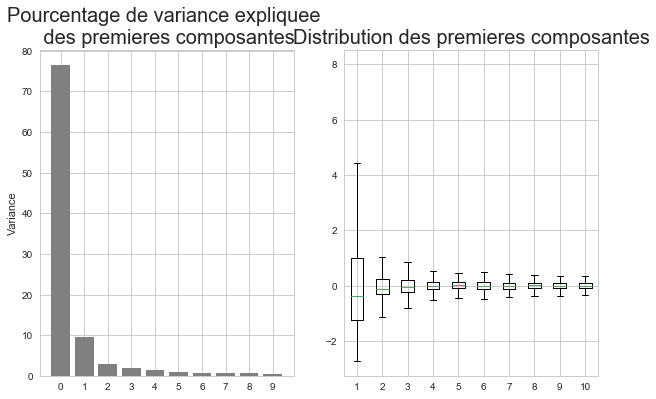

In [67]:
fig = plt.figure(figsize=(10,6))
uil.plot_variance_acp(fig, pca, X_train_fourier_pca)

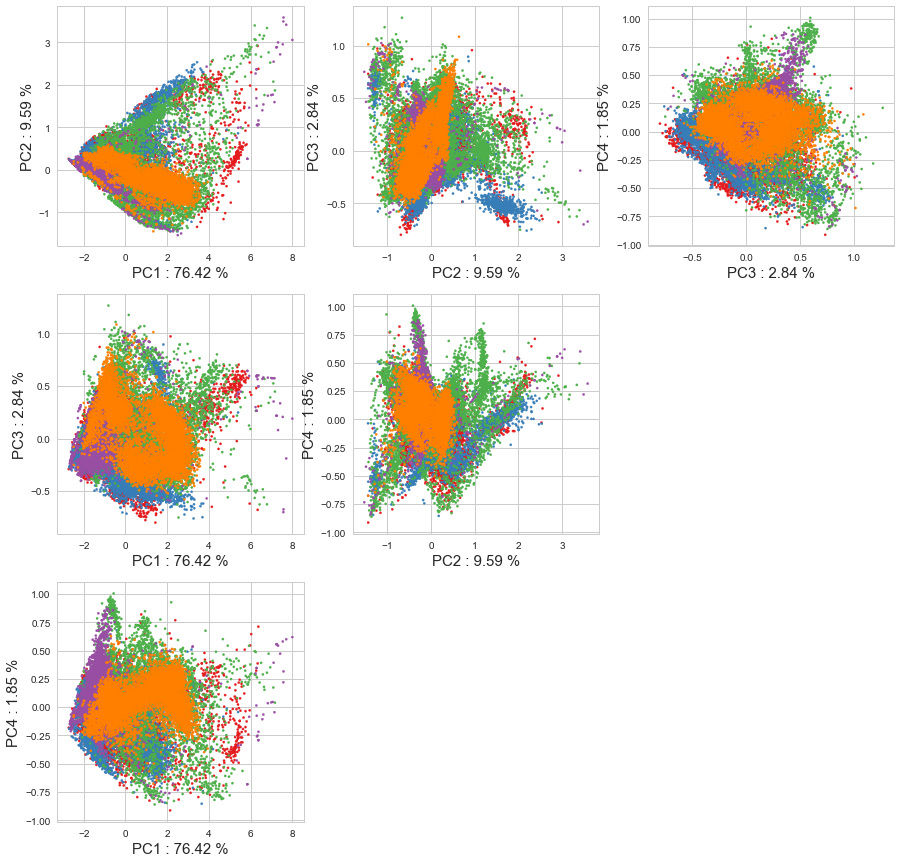

In [68]:
fig = plt.figure(figsize= (15,15))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_fourier_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

# **COMMENTAIRE** : 

Les deux premiers axes expliquent 87% de la variance, soit 32% de plus que les coefficients d'ondelettes. On s'attendrai à avoir de meilleurs résultats de prévision avec les coefficients de Fourier.

Les boxplots ne présentent pas d'outliers non plus.

Les projections des individus sont aussi donnés à titre informatif, car ne permettant pas de séparer nos différentes classes.


# 9. Implémentation des méthodes et stratégies de prévision de classe


La recherche d'une meilleure méthode de prévision suit généralement le protocole suivant dont la première étape est déjà réalisée.

Etape descriptive préliminaire multidimensionnelle et l'étape de construction de variables, attributs ou features spécifiques des données.

Procéder à un tirage aléatoire d'un échantillon test qui ne sera utilisé que lors de la dernière étape de comparaison des méthodes.

La partie restante est l'échantillon d'apprentissage pour l'estimation des paramètres des modèles.
Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par validation croisée.
* Variables à prendre en compte dans la régression linéaire ou logistique;
* nombre de feuilles dans l'arbre de régression ou de classification;
* architecture (nombre de neurones, pénalisation) du perceptron;
* algorithme d'agrégation,
* noyau et pénalisation des SVMs.

Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test.

Dans cette partie, nous allons implémenté différents algorithmes pour essayer de prévoire  la catégorie des électrocardiogrammes.

## 9.1 Logit

### Paramètres testés

In [48]:
method = LogisticRegression(penalty="l1")
param_logit=[{"C":[1,1.5,3.5,5]}]

### 9.1.1 Ondelettes non seuillées

In [70]:
ts = time.time()
result=GridSearchCV(method,param_logit,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_logit=(resultOpt.best_params_)
score_logit = resultOpt.score(X_test_db, Y_test)
ypred_logit = resultOpt.predict(X_test_db)
te = time.time()
t_total_logit = te-ts

In [71]:
print("Score : %f, time running : %d secondes" %(score_logit, t_total_logit))
print("Meilleurs parametres : " ,(param_best_logit))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_logit), index = LABELS, columns=LABELS)

Score : 0.766925, time running : 826 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2207,224,294,179,96
S,303,728,63,50,12
V,215,51,987,137,58
F,94,10,59,1132,1
Q,60,10,55,12,1471


### 9.1.2 Ondelettes seuillées

In [72]:
ts = time.time()
result=GridSearchCV(method,param_logit,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_logitth=(resultOpt.best_params_)
score_logitth = resultOpt.score(X_test_dbth, Y_test)
ypred_logitth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_logitth = te-ts

In [73]:
print("Score : %f, time running : %d secondes" %(score_logitth, t_total_logitth))
print("Meilleurs parametres : " ,(param_best_logitth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_logitth), index = LABELS, columns=LABELS)

Score : 0.764810, time running : 283 secondes
Meilleurs parametres :  {'C': 5}
Matrice de confusion: 


,N,S,V,F,Q
N,2145,249,293,213,100
S,297,736,59,51,13
V,191,42,1039,123,53
F,105,11,57,1121,2
Q,51,14,65,12,1466


### 9.1.3 Tranformation Fourier

In [ ]:
ts = time.time()
result=GridSearchCV(method,param_logit,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_best_logitF=(resultOpt.best_params_)
score_logitF = resultOpt.score(X_test_fourier, Y_test)
ypred_logitF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_logitF = te-ts

In [75]:
print("Score : %f, time running : %d secondes" %(score_logitF, t_total_logitF))
print("Meilleurs parametres : " ,(param_best_logitF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_logitF), index = LABELS, columns=LABELS)

Score : 0.776446, time running : 606 secondes
Meilleurs parametres :  {'C': 5}
Matrice de confusion: 


,N,S,V,F,Q
N,2241,295,184,175,105
S,249,724,60,69,54
V,194,18,1071,106,59
F,80,17,72,1127,0
Q,69,7,72,17,1443


La régression logistique fait partie de la famille des modèles linéaires.

Les fonctions de modèles linéaires et linéaires généralisées sont limitées dans Scikit-learn et sans sorties numériques (tests) détaillées qui sont à rechercher dans une autre librairie (StatsModels). Dans les deux cas, les stratégies classiques (forward, backward, stepwise, Furnival et Wilson) de sélection de variables par optimisation d'un critère (Cp, AIC, BIC) ne semblent pas disponibles, même si AIC et BIC sont présents dans scikit-learn.

C'est la raison pour laquelle, nous avons introduit une pénalisation Lasso, qui est une pénalisation de type L1 pour opérer une sélection de variables mais sans analyse fine des interactions comme cela est possible avec R.

La valeur par défaut du paramètre de pénalisation Lasso est 1, mais c'est un paramètre que nous optimisons par validation croisée. Ici, c'est une validation croisée 10 segments qui est implémenté. Cette opération est parallélisée grâce à l'option n_jobs=-1.Les autres paramètres sont laissées par défaut.

Nous obtenons ainsi la valeur optimale de ce paramètre qui est 5 et les scores de prévision correspondants sont : environ 76% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 77% pour les coefficients de Fourier. Ce dernier est un peu meilleur mais prenant en compte aussi le temps d'exécution, on préviligiera les coefficients seuillés avec 283 secondes, soit 3 fois moins de temps qu'avec les coefficients de Fourier.

Le taux de mal classés reste élevé (23%) et la matrice de confusion en témoigne. Aucune classe n'est totalement bien prédite.

## 9.2 KNN

In [123]:
method = KNeighborsClassifier()
param_knn=[{"n_neighbors":(list([2,5,9,13,20]))}]

### 9.2.1 Ondelettes non seuillées

In [124]:
ts = time.time()
result=GridSearchCV(method,param_knn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_knn=(resultOpt.best_params_)
score_knn = resultOpt.score(X_test_db, Y_test)
ypred_knn = resultOpt.predict(X_test_db)
te = time.time()
t_total_knn = te-ts

In [125]:
print("Score : %f, time running : %d secondes" %(score_knn, t_total_knn))
print("Meilleurs parametres : " ,(param_best_knn))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_knn), index = LABELS, columns=LABELS)

Score : 0.913141, time running : 1027 secondes
Meilleurs parametres :  {'n_neighbors': 2}
Matrice de confusion: 


,N,S,V,F,Q
N,2852,87,15,40,6
S,200,914,28,13,1
V,57,28,1332,28,3
F,67,6,96,1127,0
Q,36,9,14,5,1544


### 9.2.2 Ondelettes seuillées

In [126]:
ts = time.time()
result=GridSearchCV(method,param_knn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_knnth=(resultOpt.best_params_)
score_knnth = resultOpt.score(X_test_dbth, Y_test)
ypred_knnth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_knnth = te-ts
print("Score : %f, time running : %d secondes" %(score_knnth, t_total_knnth))
print("Meilleurs parametres : " ,(param_best_knnth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_knnth), index = LABELS, columns=LABELS)

Score : 0.911025, time running : 1024 secondes
Meilleurs parametres :  {'n_neighbors': 2}
Matrice de confusion: 


,N,S,V,F,Q
N,2850,88,16,42,4
S,209,905,25,16,1
V,61,30,1323,32,2
F,68,9,92,1127,0
Q,36,7,13,6,1546


### 9.2.3 Tranformation Fourier

In [127]:
ts = time.time()
result=GridSearchCV(method,param_knn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_best_knnF=(resultOpt.best_params_)
score_knnF = resultOpt.score(X_test_fourier, Y_test)
ypred_knnF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_knnF = te-ts


In [128]:
print("Score : %f, time running : %d secondes" %(score_knnF, t_total_knnF))
print("Meilleurs parametres : " ,(param_best_knnF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_knnF), index = LABELS, columns=LABELS)

Score : 0.895157, time running : 714 secondes
Meilleurs parametres :  {'n_neighbors': 2}
Matrice de confusion: 


,N,S,V,F,Q
N,2787,103,44,57,9
S,196,908,36,11,5
V,61,40,1302,40,5
F,77,19,106,1094,0
Q,40,12,25,6,1525


# **COMMENTAIRE** : 

La fonction estimée "non paramétriquement" par l'algorithme des k plus proches voisins est celle de la  densité conditionnelle ( nombre de points dans l'éllipsoide).

Pour knn, le choix du nombre de voisins *n_neighbors* est optimisé par validation croisée 10 segments également et  parallélisée grâce à l'option n_jobs=-1.Les autres paramètres sont laissées par défaut.

Nous obtenons ainsi la valeur optimale de ce paramètre qui est 2 et les scores de prévision correspondants sont : environ 91% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 89% pour les coefficients de Fourier. Ce dernier n'est pas le meilleur mais prenant en compte le temps d'exécution, on le préviligiera avec ses 714 secondes  au lieu de 1024 et 1027 secondes des autres. 


Cette méthode conduit à un taux de mal classés presque 3 fois moins important que le modèle logistique. On prédit mieux les classes.

## 9.3 CART

In [77]:
method = DecisionTreeClassifier()
param_cart=[{"max_depth":list([2,3,5,9])}]

### 9.3.1 Ondelettes non seuillés

In [78]:
ts = time.time()
result=GridSearchCV(method,param_cart,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_cart=(resultOpt.best_params_)
score_cart = resultOpt.score(X_test_db, Y_test)
ypred_cart = resultOpt.predict(X_test_db)
te = time.time()
t_total_cart = te-ts

In [79]:
print("Score : %f, time running : %d secondes" %(score_cart, t_total_cart))
print("Meilleurs parametres : " ,(param_best_cart))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_cart), index = LABELS, columns=LABELS)

Score : 0.877880, time running : 51 secondes
Meilleurs parametres :  {'max_depth': 9}
Matrice de confusion: 


,N,S,V,F,Q
N,2698,103,56,99,44
S,217,864,23,37,15
V,108,23,1247,58,12
F,86,14,43,1152,1
Q,58,2,32,8,1508


### 9.3.2 Ondelettes seuillées

In [80]:
ts = time.time()
result=GridSearchCV(method,param_cart,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_cartth=(resultOpt.best_params_)
score_cartth = resultOpt.score(X_test_dbth, Y_test)
ypred_cartth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_cartth = te-ts

In [81]:
print("Score : %f, time running : %d secondes" %(score_cartth, t_total_cartth))
print("Meilleurs parametres : " ,(param_best_cartth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_cartth), index = LABELS, columns=LABELS)

Score : 0.874706, time running : 24 secondes
Meilleurs parametres :  {'max_depth': 9}
Matrice de confusion: 


,N,S,V,F,Q
N,2677,142,66,88,27
S,203,862,48,40,3
V,103,16,1259,61,9
F,91,36,39,1130,0
Q,41,6,43,4,1514


### 9.3.3 Tranformation Fourier

In [82]:
ts = time.time()
result=GridSearchCV(method,param_cart,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_best_cartF=(resultOpt.best_params_)
score_cartF = resultOpt.score(X_test_fourier, Y_test)
ypred_cartF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_cartF = te-ts


In [83]:
print("Score : %f, time running : %d secondes" %(score_cartF, t_total_cartF))
print("Meilleurs parametres : " ,(param_best_cartF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_cartF), index = LABELS, columns=LABELS)

Score : 0.767866, time running : 39 secondes
Meilleurs parametres :  {'max_depth': 9}
Matrice de confusion: 


,N,S,V,F,Q
N,2237,241,237,190,95
S,277,736,82,40,21
V,132,40,1145,73,58
F,159,23,92,1019,3
Q,77,26,103,6,1396


# **COMMENTAIRE** : 

Différents paramètres contrôlent l'exécution de l'algorithme:  le nombre minimal d'observation par noeud, le nombre de validations croisées (par défaut 10), la profondeur maximale etc. En effet, es arbres de décision  sont bien implémentés dans scikit-learn mais avec une insuffisance pour leur élagage. Ce n'est pas une pénalisation de la complexité, et donc précisément le nombre de feuilles qui est optimisé, mais la profondeur globale de l'arbre au risque d'élaguer, à une profondeur donnée, des feuilles importantes ou de conserver des feuilles ambigües. Le critère  optimisé lors de la création d'un noeud de l'arbre est la minimisation de l'hétérogénéité des classes ou la maximisation de  l'homogénéité des classes.
maximale
Comme précédemment, la validation croisée permet d'optimiser le paramètre de profondeur maximale sur une grille avec une validation croisée 10 segments.On n'oublie pas de paraléliser ce traitement .Les autres paramètres sont laissées par défaut.

Nous obtenons ainsi la valeur optimale de ce paramètre qui est 9 et les scores de prévision correspondants sont : environ 87% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 76% pour les coefficients de Fourier.On préviligiera ar cette méthode les coefficients seuillés avec 24 secondes à l'exécution pour le meilleur taux ici.


A ce stade, les k plus proches voisins fournissent de meilleurs résultat que le modèle logistique et les arbres de décision.

## 9.4 Neuron network

In [84]:
method = MLPClassifier(max_iter=500)
param_nn=[{"hidden_layer_sizes":list([2,5,9,15])}]

### 9.4.1 Ondelettes non seuillées

In [85]:
ts = time.time()
result=GridSearchCV(method,param_nn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_nn=(resultOpt.best_params_)
score_nn = resultOpt.score(X_test_db, Y_test)
ypred_nn = resultOpt.predict(X_test_db)
te = time.time()
t_total_nn = te-ts

In [86]:
print("Score : %f, time running : %d secondes" %(score_nn, t_total_nn))
print("Meilleurs parametres : " ,(param_best_nn))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_nn), index = LABELS, columns=LABELS)

Score : 0.881993, time running : 494 secondes
Meilleurs parametres :  {'hidden_layer_sizes': 15}
Matrice de confusion: 


,N,S,V,F,Q
N,2640,162,50,106,42
S,179,896,25,38,18
V,66,15,1282,75,10
F,73,25,58,1139,1
Q,24,10,15,12,1547


### 9.4.2 Ondelettes seuillées

In [87]:
ts = time.time()
result=GridSearchCV(method,param_nn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_nnth=(resultOpt.best_params_)
score_nnth = resultOpt.score(X_test_dbth, Y_test)
ypred_nnth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_nnth = te-ts

In [88]:
print("Score : %f, time running : %d secondes" %(score_nnth, t_total_nnth))
print("Meilleurs parametres : " ,(param_best_nnth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_nnth), index = LABELS, columns=LABELS)

Score : 0.882934, time running : 540 secondes
Meilleurs parametres :  {'hidden_layer_sizes': 15}
Matrice de confusion: 


,N,S,V,F,Q
N,2631,162,52,103,52
S,193,904,21,30,8
V,55,20,1284,77,12
F,58,25,63,1149,1
Q,30,9,21,4,1544


### 9.4.3 Tranformation Fourier

In [89]:
ts = time.time()
result=GridSearchCV(method,param_nn,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_best_nnF=(resultOpt.best_params_)
score_nnF = resultOpt.score(X_test_fourier, Y_test)
ypred_nnF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_nnF = te-ts


In [90]:
print("Score : %f, time running : %d secondes" %(score_nnF, t_total_nnF))
print("Meilleurs parametres : " ,(param_best_nnF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_nnF), index = LABELS, columns=LABELS)

Score : 0.837800, time running : 373 secondes
Meilleurs parametres :  {'hidden_layer_sizes': 15}
Matrice de confusion: 


,N,S,V,F,Q
N,2464,229,112,151,44
S,224,790,52,66,24
V,107,9,1205,99,28
F,59,27,61,1149,0
Q,38,9,33,8,1520


# **COMMENTAIRE** : 

Il s'agit pour cette algorithme d'estimer un modèle de type perceptron avec en entrée les feautures et en sortie la variable à prévoir. 


Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première conciste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage convient parfaitement pour une application raisonnable du perceptron.  

D'autres façons déviter le sur-apprentissage:
choix du nombre de paramètres(nombre de couches, choix de la fonction de transfert...)et du nombre max d'itération par validation croisée.

En effet, la validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence :
nombre de neurones, le coeffiecient de pénalisation L2 (alpha) et éventuellement le nombre max d'itérations.


Le nombre max d'itérations par défaut (200) semble insuffisant. Il est fixé à 500, et la fonction d'activation est laissée par défaut: Relu en python. Seul le le nombre de neurones est optimisé par une validation croisé 10 segments.

Nous obtenons ainsi la valeur optimale de ce paramètre qui est 15 et les scores de prévision correspondants sont : environ 88% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 83% pour les coefficients de Fourier. Ce dernier s'éxécute en  373 secondes. Mais on préviligiera les coefficients d'ondelettes avec un peu plus de temps d'éxécution mais un meilleur score.


Les réseaux de neurones fournissent une bonne prévision, même si la matrice de confusion est loin d'être diagonale.


## 9.5 Random Forest

### Paramètres testés

In [91]:
method=RandomForestClassifier()
param_rf=[{"max_features":[2,4,7,9],'n_estimators':[100,200]}]

### 9.5.1 Ondelettes non seuillées

In [92]:
ts = time.time()
result=GridSearchCV(method,param_rf,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_rf=(resultOpt.best_params_)
score_rf = resultOpt.score(X_test_db, Y_test)
ypred_rf = resultOpt.predict(X_test_db)
te = time.time()
t_total_rf = te-ts

In [93]:
print("Score : %f, time running : %d secondes" %(score_rf, t_total_rf))
print("Meilleurs parametres : " ,(param_best_rf))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_rf), index = LABELS, columns=LABELS)

Score : 0.937706, time running : 778 secondes
Meilleurs parametres :  {'max_features': 9, 'n_estimators': 200}
Matrice de confusion: 


,N,S,V,F,Q
N,2940,33,13,12,2
S,182,934,13,22,5
V,49,6,1366,26,1
F,74,5,41,1176,0
Q,30,1,15,0,1562


### 9.5.2 Ondelettes seuillées

In [94]:
ts = time.time()
result=GridSearchCV(method,param_rf,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_rfth=(resultOpt.best_params_)
score_rfth = resultOpt.score(X_test_dbth, Y_test)
ypred_rfth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_rfth = te-ts

In [95]:
print("Score : %f, time running : %d secondes" %(score_rfth, t_total_rfth))
print("Meilleurs parametres : " ,(param_best_rfth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_rfth), index = LABELS, columns=LABELS)

Score : 0.941114, time running : 434 secondes
Meilleurs parametres :  {'max_features': 9, 'n_estimators': 200}
Matrice de confusion: 


,N,S,V,F,Q
N,2904,44,19,29,4
S,163,964,15,10,4
V,34,5,1378,29,2
F,58,3,54,1181,0
Q,17,2,9,0,1580


### 9.5.3 Transformation de Fourier

In [96]:
ts = time.time()
result=GridSearchCV(method,param_rf,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_best_rfF=(resultOpt.best_params_)
score_rfF = resultOpt.score(X_test_fourier, Y_test)
ypred_rfF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_rfF = te-ts


In [97]:
print("Score : %f, time running : %d secondes" %(score_rfF, t_total_rfF))
print("Meilleurs parametres : " ,(param_best_rfF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_rfF), index = LABELS, columns=LABELS)

Score : 0.873648, time running : 1163 secondes
Meilleurs parametres :  {'max_features': 9, 'n_estimators': 200}
Matrice de confusion: 


,N,S,V,F,Q
N,2751,77,91,50,31
S,261,819,48,22,6
V,113,4,1271,43,17
F,109,15,73,1099,0
Q,45,4,64,2,1493


# **COMMENTAIRE** : 

Avec les forêts aléatoires, nous optimisons par validation croisée 10 segments le nombres maximun de features à prendre en compte et le nombre d'arbres de la forêt.

Nous obtenons ainsi la valeur optimale de ce paramètre qui est 9 et les scores de prévision correspondants sont : environ 93% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 87% pour les coefficients de Fourier. Ce dernier prend beaucoup de temps d'exécution, on préviligiera les coefficients seuillés avec 434 secondes, soit 3 fois moins de temps qu'avec les coefficients de Fourier.


Le meilleur score jusqu'ici.
On remarque dès lors que les méthodes non linéaires semblent donner de meilleurs résultats.



## 9.6 SVM Linéaire

#### Paramètres testés

In [98]:
param_SVM_linear=[{"C":[0.4,0.8,1,1.5]}]
cv=10
method=SVC(kernel='linear')

### 9.6.1 Ondelettes non seuillées

In [99]:
ts = time.time()
result=GridSearchCV(method,param_SVM_linear,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_bestSVML=(resultOpt.best_params_)
scoreSVML = resultOpt.score(X_test_db, Y_test)
ypredSVML = resultOpt.predict(X_test_db)
te = time.time()
t_totalSVML = te-ts

In [100]:
print("Score : %f, time running : %d secondes" %(scoreSVML, t_totalSVML))
print("Meilleurs parametres : " ,(param_bestSVML))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypredSVML), index = LABELS, columns=LABELS)

Score : 0.797250, time running : 4615 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2352,111,303,176,58
S,347,686,65,51,7
V,198,24,1121,83,22
F,71,12,48,1164,1
Q,80,4,55,9,1460


### 9.6.2 Ondelettes seuillées

In [101]:
method=SVC(kernel='linear')
ts = time.time()
result=GridSearchCV(method,param_SVM_linear,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_bestSVMLth=(resultOpt.best_params_)
scoreSVMLth = resultOpt.score(X_test_dbth, Y_test)
ypredSVMLth = resultOpt.predict(X_test_dbth)
te = time.time()
t_totalSVMLth = te-ts

In [102]:
print("Score : %f, time running : %d secondes" %(scoreSVMLth, t_totalSVMLth))
print("Meilleurs parametres : " ,(param_bestSVMLth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypredSVMLth), index = LABELS, columns=LABELS)

Score : 0.800541, time running : 4564 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2371,114,261,196,58
S,351,694,63,42,6
V,189,28,1126,89,16
F,87,3,53,1152,1
Q,64,6,62,8,1468


### 9.6.3 Transformation Fourier

In [103]:
method=SVC(kernel='linear')
ts = time.time()
result=GridSearchCV(method,param_SVM_linear,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier, Y_train)
param_bestSVMLF=(resultOpt.best_params_)
scoreSVMLF = resultOpt.score(X_test_fourier, Y_test)
ypredSVMLF = resultOpt.predict(X_test_fourier)
te = time.time()
t_totalSVMLF = te-ts


In [104]:
print("Score : %f, time running : %d secondes" %(scoreSVMLF, t_totalSVMLF))
print("Meilleurs parametres : " ,(param_bestSVMLF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypredSVMLF), index = LABELS, columns=LABELS)

Score : 0.811119, time running : 3081 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2451,216,137,159,37
S,273,739,58,60,26
V,161,12,1145,98,32
F,78,18,66,1134,0
Q,87,10,75,4,1432


# **COMMENTAIRE** : 

Malgré les assurances théoriques concernant ce type d'algorithme, les résultats dépendant fortement du choix des paramètres, même en python.Le temps d'exécution pour les SVM est plus sensible au nombre d'observations  n= nombre de contraintes de notre optimisation (optimisation sous contraintes).

Nous nous limiterons d'abord au noyau linéaire.

L'optimisation de la pénalisation (paramètre C) est recherchée sur une grille par validation croisée 10 segments. 


Nous obtenons ainsi la valeur optimale de ce paramètre qui est 1.5 et les scores de prévision correspondants sont : environ 80% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 81% pour les coefficients de Fourier. Ce dernier prend beaucoup moins de temps d'exécution avec un meilleur score, on le préviligiera. 

Le taux d'erreur est toutefois de 19% ,non acceptable par rapport aux autres méthodes.

## 9.7 SVM Gaussien

### Paramètres testés

In [105]:
method=SVC(kernel='rbf')
param_SVMG=[{"C":[0.4,0.8,1,1.5]}]
cv=10

### 9.7.1 Ondelettes non seuillées

In [106]:
ts = time.time()
result=GridSearchCV(method,param_SVMG,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_db, Y_train)
param_best_SVMG=(resultOpt.best_params_)
score_SVMG = resultOpt.score(X_test_db, Y_test)
ypred_SVMG = resultOpt.predict(X_test_db)
te = time.time()
t_total_SVMG = te-ts

In [107]:
print("Score : %f, time running : %d secondes" %(score_SVMG, t_total_SVMG))
print("Meilleurs parametres : " ,(param_best_SVMG))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_SVMG), index = LABELS, columns=LABELS)

Score : 0.796074, time running : 6443 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2399,144,156,270,31
S,377,666,56,53,4
V,160,20,1145,113,10
F,106,8,43,1139,0
Q,138,0,36,10,1424


### 9.7.2 Ondelettes seuillées

In [108]:
ts = time.time()
result=GridSearchCV(method,param_SVMG,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_dbth, Y_train)
param_best_SVMGth=(resultOpt.best_params_)
score_SVMGth = resultOpt.score(X_test_dbth, Y_test)
ypred_SVMGth = resultOpt.predict(X_test_dbth)
te = time.time()
t_total_SVMGth = te-ts

In [109]:
print("Score : %f, time running : %d secondes" %(score_SVMGth, t_total_SVMGth))
print("Meilleurs parametres : " ,(param_best_SVMGth))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_SVMGth), index = LABELS, columns=LABELS)

Score : 0.791843, time running : 6211 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2398,139,153,279,31
S,375,663,59,53,6
V,168,21,1123,112,24
F,113,6,45,1132,0
Q,136,1,39,11,1421


### 9.7.3 Transformation de Fourier

In [110]:
ts = time.time()
result=GridSearchCV(method,param_SVMG,cv=10,n_jobs=-1)
resultOpt=result.fit(X_train_fourier,Y_train)
param_best_SVMGF=(resultOpt.best_params_)
score_SVMGF = resultOpt.score(X_test_fourier, Y_test)
ypred_SVMGF = resultOpt.predict(X_test_fourier)
te = time.time()
t_total_SVMGF = te-ts

In [111]:
print("Score : %f, time running : %d secondes" %(score_SVMGF, t_total_SVMGF))
print("Meilleurs parametres : " ,(param_best_SVMGF))
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_SVMGF), index = LABELS, columns=LABELS)

Score : 0.750353, time running : 4069 secondes
Meilleurs parametres :  {'C': 1.5}
Matrice de confusion: 


,N,S,V,F,Q
N,2148,304,171,347,30
S,372,595,61,87,41
V,181,4,1096,141,26
F,72,8,57,1159,0
Q,112,1,95,14,1386


# **COMMENTAIRE** : 
Nous réimplémentons la SVM avec cette fois ci un noyau gaussien. La pénalisation optimale est la même.

Les scores de prévision correspondants sont : environ 79% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 75% pour les coefficients de Fourier. Ce dernier prend beaucoup moins de temps d'exécution .

La SVM non- linéaire correspond mieux à notre problématique ici que celle linéaire, mais donne quasiment le même résultat que celle linéaire sur les coefficients d'ondelettes et fait moins bien sur les coefficients de Fourier.


## 9.8 Xgboost

### Paramètres testés

In [259]:
method=xgb.XGBClassifier()
max_depth= [4,6,10]
n_estimators=[100,200,250]

In [260]:
def xgboost(max_depth,n_estimators,Xr_train, Y_train,Xr_test, Y_test):
    ts = time.time()
    xgboost=xgb.XGBClassifier(max_depth=max_depth,
       n_estimators=n_estimators,
       objective= 'multi:softprob',
       num_class=5, n_jobs=-1,cv=10)
    xgboost.fit(Xr_train, Y_train)
    score = xgboost.score(Xr_test, Y_test)
    ypred = xgboost.predict(Xr_test)
    te = time.time()
    t_total = te-ts
    return score,ypred,t_total   

### 9.8.1 Ondelettes non seuillées

In [261]:
result_xgb=[]
ypred_xgb=[]
for i in range(len(max_depth)):
        for k in range(len(n_estimators)):
            score_xgb,ypred,t_total_xgb=xgboost(max_depth[i],n_estimators[k],X_train_db, Y_train,X_test_db, Y_test)
            ypred_xgb.append(ypred)
            result_xgb.append([score_xgb,max_depth[i],n_estimators[k],t_total_xgb])

In [262]:
result_xgb=pd.DataFrame(result_xgb)
result_xgb.columns=["Score", "max_depth", "n_estimators","time"]
n=np.argmax(result_xgb.values[:,0])

In [263]:
print('Le mmeilleur score: \n',result_xgb.loc[[n]])
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_xgb[n]), index = LABELS, columns=LABELS)

Le mmeilleur score: 
       Score  max_depth  n_estimators        time
7  0.949929         10           200  308.558718
Matrice de confusion: 


,N,S,V,F,Q
N,2934,34,16,10,6
S,133,982,16,18,7
V,26,2,1398,20,2
F,58,7,45,1186,0
Q,10,3,13,0,1582


### 9.8.2 Ondelettes seuillées

In [264]:
result_xgbth=[]
ypred_xgbth=[]
for i in range(len(max_depth)):
        for k in range(len(n_estimators)):
            score_xgbth,ypred,t_total_xgbth=xgboost(max_depth[i],n_estimators[k],X_train_dbth, Y_train,X_test_dbth, Y_test)
            ypred_xgbth.append(ypred)
            result_xgbth.append([score_xgbth,max_depth[i],n_estimators[k],t_total_xgbth])

In [265]:
result_xgbth=pd.DataFrame(result_xgbth)
result_xgbth.columns=["Score", "max_depth", "n_estimators","time"]
n=np.argmax(result_xgbth.values[:,0])

In [266]:
print('Le mmeilleur score: \n',result_xgbth.loc[[n]])
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_xgbth[n]), index = LABELS, columns=LABELS)

Le mmeilleur score: 
       Score  max_depth  n_estimators        time
8  0.949459         10           250  234.460319
Matrice de confusion: 


,N,S,V,F,Q
N,2907,50,19,12,12
S,113,1004,17,17,5
V,20,2,1398,26,2
F,60,7,46,1182,1
Q,10,3,8,0,1587


### 9.8.3 Transformation de Fourier

In [267]:
result_xgbF=[]
ypred_xgbF=[]
for i in range(len(max_depth)):
        for k in range(len(n_estimators)):
            score_xgbF,ypred,t_total_xgbF=xgboost(max_depth[i],n_estimators[k],X_train_fourier, Y_train,X_test_fourier, Y_test)
            ypred_xgbF.append(ypred)
            result_xgbF.append([score_xgbF,max_depth[i],n_estimators[k],t_total_xgbF])
       

In [268]:
result_xgbF=pd.DataFrame(result_xgbF)
result_xgbF.columns=["Score", "max_depth", "n_estimators","time"]
n=np.argmax(result_xgbF.values[:,0])

In [269]:
print('Le mmeilleur score: \n',result_xgbF.loc[[n]])
print("Matrice de confusion: ")
pd.DataFrame(confusion_matrix(Y_test, ypred_xgbF[n]), index = LABELS, columns=LABELS)

Le mmeilleur score: 
       Score  max_depth  n_estimators        time
8  0.905501         10           250  321.830331
Matrice de confusion: 


,N,S,V,F,Q
N,2814,79,56,29,22
S,209,877,42,19,9
V,63,3,1331,33,18
F,72,18,68,1138,0
Q,17,6,41,0,1544


# **COMMENTAIRE** : 

On implémente XGB en optimisant les trois paramètres: profondeur et nombre d'arbres les autres paramètres sont laissés par défaut. L'optimisation des paramètres est faite manuellement avec une validation croisée de 10 segments.

Le meilleur modèle retenu est celui de profondeur 10 et avec 250 arbres. 

Les scores de prévision correspondants sont : environ 94% pour les coefficients d'ondelettes, seuillés ou pas et d'environ 90% pour les coefficients de Fourier. Avec les coefficients d'ondelettes, on a le meilleur score avec le meilleur temps d'éxécution.

# 10. Apprentissage profond sur les signaux

Cette deuxième étape s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant, par exemple, un algorithme d'apprentissage profond sur les données brutes ou leur transformation en ondelettes ? C'est la question à laquelle nous allons tenter de répondre.


L'idée pertinente avec ces données est d'identifier le problème lié au déphasage des signaux. L'utilisation d'une couche convolutionnelle introduit une propriété d'invariance par translation. Les caractéristiques ou features sortant de cette couche acquièrent donc ainsi de bonnes propriétés avant d'être dirigées vers des couches techniques intermédiaires (MaxPooling, Flatten) et une dernière couche de sortie qui effectue la discrimination à partir des caractéristiques.



In [35]:
LABELS = ['N','S','V','F','Q']
PATHOLOGY = {
    0: 'N',
    1: 'S',
    2: 'V',
    3: 'F',
    4: 'Q'
}
def my_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([PATHOLOGY[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([PATHOLOGY[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [36]:
# Lecture des données d'apprentissage
n_classes = 5
# path="" # Si les données sont dans le répertoire courant sinon:
path=""
Dtrain=pd.read_csv(path+"train/train.csv",header=None)
X_train_2d = Dtrain.values[:,:-1]
Y_train = Dtrain.values[:,-1]

Dtest=pd.read_csv(path+"test/test.csv",header=None)
X_test_2d = Dtest.values[:,:-1]
Y_test = Dtest.values[:,-1]

In [37]:
import keras.utils as ku
Y_train_ecg = ku.to_categorical(Y_train, n_classes)
Y_test_ecg = ku.to_categorical(Y_test, n_classes)

In [38]:
X_train=np.reshape(X_train_2d,(X_train_2d.shape[0],X_train_2d.shape[1],1))
X_test=np.reshape(X_test_2d,(X_test_2d.shape[0],X_test_2d.shape[1],1))

In [43]:
n_classes=5
epochs = 10
batch_size = 32
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])

## 10.1 Réseau convolutionnel 1D une couche

Dans un premier temps, nous implémentons un réseau de neurone 1D simple:
* une couche de *convolution* avec 32 fitres de taille 9, avec la fonction d'activation ReLu
* une couche de *max_pooling* de size 3 pour garder des coefficients maximaux
* une couche de *flatten* pour transformer matrice en vecteur
* une couche de *classification* multiclasse avec la fonction *softmax*

In [170]:
model_base_conv_1D =km.Sequential()
model_base_conv_1D.add(kl.Conv1D(32, 9, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_1D.add(kl.MaxPooling1D(pool_size=3))
model_base_conv_1D.add(kl.Flatten())
model_base_conv_1D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_1D.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_base_conv_1D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 179, 32)           320       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 59, 32)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1888)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 9445      
Total params: 9,765
Trainable params: 9,765
Non-trainable params: 0
_________________________________________________________________


In [171]:
t_start = time.time()
model_base_conv_1D.fit(X_train,  Y_train_ecg, batch_size=batch_size, validation_data=(X_test, Y_test_ecg), epochs=epochs)
t_end = time.time()
t_learning_1 = t_end-t_start

Train on 30041 samples, validate on 8508 samples
Epoch 1/10
30041/30041 [==============================] - 18s 587us/step - loss: 0.8226 - acc: 0.7044 - val_loss: 0.6363 - val_acc: 0.7764
Epoch 2/10
30041/30041 [==============================] - 14s 466us/step - loss: 0.5832 - acc: 0.7974 - val_loss: 0.5291 - val_acc: 0.8201
Epoch 3/10
30041/30041 [==============================] - 10s 346us/step - loss: 0.4908 - acc: 0.8319 - val_loss: 0.4789 - val_acc: 0.8399
Epoch 4/10
30041/30041 [==============================] - 11s 355us/step - loss: 0.4474 - acc: 0.8472 - val_loss: 0.4462 - val_acc: 0.8486
Epoch 5/10
30041/30041 [==============================] - 10s 335us/step - loss: 0.4235 - acc: 0.8555 - val_loss: 0.4358 - val_acc: 0.8508
Epoch 6/10
30041/30041 [==============================] - 10s 342us/step - loss: 0.4067 - acc: 0.8605 - val_loss: 0.4257 - val_acc: 0.8571
Epoch 7/10
30041/30041 [==============================] - 10s 341us/step - loss: 0.3940 - acc: 0.8650 - val_loss: 0.4

In [172]:
score_1 = model_base_conv_1D.evaluate(X_test, Y_test_ecg)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score_1*100, t_learning_1) )
metadata_conv = {"time_learning" : t_learning, "score" : score_1}
base_conv_1D_prediction = model_base_conv_1D.predict(X_test)
print("Matrice de confusion: ")
my_confusion_matrix(Y_test_ecg, base_conv_1D_prediction)

8508/8508 [==============================] - 1s 123us/step
Score With Conv on Multidimensional Inertial Signals = 85.54, Learning time = 114.90 secondes
Matrice de confusion: 


Pred,F,N,Q,S,V
True,,,,,
F,1178,44,0,25,49
N,208,2429,42,251,70
Q,12,35,1529,9,23
S,52,197,6,855,46
V,90,44,9,18,1287


## **COMMENTAIRE:** 
Nous obtenons un score de prévision de 85% en 114 secondes. Le temps est remarquable et la prévision acceptable.

## 10.2 Réseau convolutionnel 1D multicouches

Dans cette partie, nous essayons un réseau de neurone 1D avec plusieurs couches de convolution. Nous construissons 2 réseaux avec les mêmes couches de convolution et mêmes  couches max_pooling mais l'un sans couche dropout et l'autre avec la couche dropout de coefficient 0.2 (supprimer 20% paramètres aléatoirement) après chaque couche max_pooling.

### Sans dropout

In [173]:
model_base_conv_mult =km.Sequential()
model_base_conv_mult.add(kl.Conv1D(32, 5, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_mult.add(kl.MaxPooling1D(pool_size=3))


model_base_conv_mult.add(kl.Conv1D(filters = 32, kernel_size = 5,strides = 1, activation = 'relu'))
model_base_conv_mult.add(kl.MaxPooling1D(pool_size = 3))

model_base_conv_mult.add(kl.Conv1D(filters = 32, kernel_size = 5,strides = 1, activation = 'relu'))
model_base_conv_mult.add(kl.MaxPooling1D(pool_size = 3))
                         
model_base_conv_mult.add(kl.Flatten())
model_base_conv_mult.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_mult.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_base_conv_mult.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 183, 32)           192       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 61, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 57, 32)            5152      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 15, 32)            5152      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5, 32)             0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 160)               0         
__________

In [174]:
t_start = time.time()
model_base_conv_mult.fit(X_train,  Y_train_ecg, batch_size=batch_size, validation_data=(X_test, Y_test_ecg), epochs=epochs)
t_end = time.time()
t_learning_mult = t_end-t_start
score_mult = model_base_conv_mult.evaluate(X_test, Y_test_ecg)[1] 

Train on 30041 samples, validate on 8508 samples
Epoch 1/10
30041/30041 [==============================] - 15s 491us/step - loss: 0.7766 - acc: 0.7221 - val_loss: 0.5664 - val_acc: 0.7974
Epoch 2/10
30041/30041 [==============================] - 14s 476us/step - loss: 0.5001 - acc: 0.8258 - val_loss: 0.5709 - val_acc: 0.7652
Epoch 3/10
30041/30041 [==============================] - 14s 454us/step - loss: 0.4211 - acc: 0.8548 - val_loss: 0.4207 - val_acc: 0.8499
Epoch 4/10
30041/30041 [==============================] - 14s 468us/step - loss: 0.3722 - acc: 0.8728 - val_loss: 0.4465 - val_acc: 0.8287
Epoch 5/10
30041/30041 [==============================] - 15s 488us/step - loss: 0.3361 - acc: 0.8851 - val_loss: 0.3713 - val_acc: 0.8787
Epoch 6/10
30041/30041 [==============================] - 13s 448us/step - loss: 0.3095 - acc: 0.8952 - val_loss: 0.3438 - val_acc: 0.8863
Epoch 7/10
30041/30041 [==============================] - 13s 436us/step - loss: 0.2883 - acc: 0.9036 - val_loss: 0.3

In [175]:
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score_mult*100, t_learning_mult) )
metadata_conv = {"time_learning" : t_learning_mult, "score" : score_mult}
base_conv_1D_prediction_mult = model_base_conv_mult.predict(X_test)
print("Matrice de confusion: ")
my_confusion_matrix(Y_test_ecg, base_conv_1D_prediction_mult)

Score With Conv on Multidimensional Inertial Signals = 90.62, Learning time = 140.70 secondes
Matrice de confusion: 


Pred,F,N,Q,S,V
True,,,,,
F,1125,75,0,16,80
N,50,2761,12,122,55
Q,2,19,1568,5,14
S,15,187,4,908,42
V,45,31,1,23,1348


### Avec dropout

In [44]:
model_base_conv_multD =km.Sequential()
model_base_conv_multD.add(kl.Conv1D(32, 5, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_multD.add(kl.MaxPooling1D(pool_size=3))

model_base_conv_multD.add(kl.Dropout(0.2))

model_base_conv_multD.add(kl.Conv1D(filters = 32, kernel_size = 5,strides = 1, activation = 'relu'))
model_base_conv_multD.add(kl.MaxPooling1D(pool_size = 3))
model_base_conv_multD.add(kl.Dropout(0.2))

model_base_conv_multD.add(kl.Conv1D(filters = 32, kernel_size = 5,strides = 1, activation = 'relu'))
model_base_conv_multD.add(kl.MaxPooling1D(pool_size = 3))
model_base_conv_multD.add(kl.Dropout(0.2))
                         
model_base_conv_multD.add(kl.Flatten())
model_base_conv_multD.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_multD.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_base_conv_multD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 183, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 61, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 57, 32)            5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 32)            5152      
__________

In [45]:
t_start = time.time()
model_base_conv_multD.fit(X_train,  Y_train_ecg, batch_size=batch_size, validation_data=(X_test, Y_test_ecg), epochs=epochs)
t_end = time.time()
t_learning_multD = t_end-t_start
score_multD = model_base_conv_multD.evaluate(X_test, Y_test_ecg)[1] 

Train on 30041 samples, validate on 8508 samples
Epoch 1/10
30041/30041 [==============================] - 81s 3ms/step - loss: 0.9343 - acc: 0.6489 - val_loss: 0.6387 - val_acc: 0.7657
Epoch 2/10
30041/30041 [==============================] - 20s 671us/step - loss: 0.6410 - acc: 0.7731 - val_loss: 0.5583 - val_acc: 0.8103
Epoch 3/10
30041/30041 [==============================] - 17s 555us/step - loss: 0.5507 - acc: 0.8079 - val_loss: 0.4608 - val_acc: 0.8340
Epoch 4/10
30041/30041 [==============================] - 17s 563us/step - loss: 0.4993 - acc: 0.8262 - val_loss: 0.4376 - val_acc: 0.8434
Epoch 5/10
30041/30041 [==============================] - 16s 531us/step - loss: 0.4672 - acc: 0.8341 - val_loss: 0.4281 - val_acc: 0.8439
Epoch 6/10
30041/30041 [==============================] - 16s 546us/step - loss: 0.4425 - acc: 0.8429 - val_loss: 0.3767 - val_acc: 0.8675
Epoch 7/10
30041/30041 [==============================] - 17s 552us/step - loss: 0.4185 - acc: 0.8518 - val_loss: 0.375

In [46]:
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score_multD*100, t_learning_multD) )
metadata_conv = {"time_learning" : t_learning_multD, "score" : score_multD}
base_conv_1D_prediction_multD = model_base_conv_multD.predict(X_test)
print("Matrice de confusion: ")
my_confusion_matrix(Y_test_ecg, base_conv_1D_prediction_multD)

Score With Conv on Multidimensional Inertial Signals = 88.43, Learning time = 234.66 secondes
Matrice de confusion: 


Pred,F,N,Q,S,V
True,,,,,
F,1164,40,0,30,62
N,139,2647,20,149,45
Q,7,32,1552,5,12
S,43,200,1,882,30
V,79,48,12,30,1279


# **COMMENTAIRE** : 

Nous obtenons un meilleur score sans droput: 90% en moins de temps. Ce taux est très bien et parfait pour 140 secondes.

# 11. Comparaison des prévisions

In [270]:
n1=np.argmax(result_xgb.values[:,0])
n2=np.argmax(result_xgbth.values[:,0])
n3=np.argmax(result_xgbF.values[:,0])
result_xgb=np.array(result_xgb)
result_xgbth=np.array(result_xgbth)
result_xgbF=np.array(result_xgbF)

In [271]:
comparaison=np.array([['Logistique Ondelettes',score_logit,t_total_logit],
                   ['Logistique Ondelettes Seuillées',score_logitth,t_total_logitth],
                   ['Logistique Fourier',score_logitF,t_total_logitF],
                   ['KNN Ondelettes',score_knn,t_total_knn],
                   ['KNN Ondelettes Seuillées',score_knnth,t_total_knnth],
                   ['KNN Fourier',score_knnF,t_total_knnF],
                   ['CART Ondelettes',score_cart,t_total_cart],
                   ['CART Ondelettes Seuillées',score_cartth,t_total_cartth],
                   ['CART Fourier',score_cartF,t_total_cartF],
                   ['Reseau de neurones Ondelettes',score_nn,t_total_nn],
                   ['Reseau de neurones Ondelettes Seuillées',score_nnth,t_total_nnth],
                   ['Reseau de neurones Fourier',score_nnF,t_total_nnF],
                   ['Random forest Ondelettes',score_rf,t_total_rf],
                   ['Random forest Ondelettes Seuillées',score_rfth,t_total_rfth],
                   ['Random forest Fourier',score_rfF,t_total_rfF],
                   ['SVM lineaire Ondelettes',scoreSVML,t_totalSVML],
                   ['SVM lineaire Ondelettes Seuillées',scoreSVMLth,t_totalSVMLth],
                   ['SVM lineaire Fourier',scoreSVMLF,t_totalSVMLF],
                   ['SVM Gaussien Ondelettes',score_SVMG,t_total_SVMG],
                   ['SVM Gaussien Ondelettes Seuillées',score_SVMGth,t_total_SVMGth],
                   ['SVM Gaussien Fourier',score_SVMGF,t_total_SVMGF],
                   ['XGB Ondelettes',result_xgb[n1,0],result_xgb[n1,3]],
                   ['XGB Ondelettes Seuillées',result_xgbth[n1,0],result_xgbth[n1,3]],
                   ['XGB Fourier',result_xgbF[n1,0],result_xgbF[n1,3]],
                   ['CNN 1D une couche ',score_1,t_learning_1],
                   ['CNN 1D multicouches sans dropout',score_mult,t_learning_mult],
                   ['CNN 1D multicouches avec dropout',score_multD,t_learning_multD]])

In [272]:
comparaisonDF=pd.DataFrame(comparaison)

In [273]:
comparaisonDF.columns=['Methode','Score','Time']
comparaisonDF=comparaisonDF.sort_values(by='Score', ascending=False)

In [275]:
comparaisonDF

,Methode,Score,Time
21,XGB Ondelettes,0.949929478138,308.558718443
22,XGB Ondelettes Seuillées,0.947813822285,192.494211197
13,Random forest Ondelettes Seuillées,0.941114245416,434.1326858997345
12,Random forest Ondelettes,0.937705688764,778.8140451908112
3,KNN Ondelettes,0.913140573578,1027.4927628040314
4,KNN Ondelettes Seuillées,0.911024917724,1024.517924785614
25,CNN 1D multicouches sans dropout,0.906205923892,140.70381021499634
23,XGB Fourier,0.902797367184,263.440152884
5,KNN Fourier,0.895157498825,714.8644495010376
26,CNN 1D multicouches avec dropout,0.891161259907,164.54749202728271


# Conclusion

Dans ce projet, nous avons préparer les données en réequilibrant nos classes et en créant nos features.

Nous avons ensuite décomposé les signaux dans la base des ondelettes de Haar et dans la base de Fourier. Sur les coefficients obtenus, nous avons testé 8 méthodes de prévisions regroupées en deux grandes classes:

    celles linéaires: Régression Logistique, SVM linéaire,

    celles non linéaires: k plus proches voisins, arbres de décision, réseau de neurones, forêts aléatoires , SVM avec noyau gaussien et xgboost.
   
A ceux-ci, nous avons rajouté un apprentissage profond.

Sur nos données, les méthodes non-linéaires marchent mieux que les méthodes linéaires. En effet, Extrem Gradient Boosting donne le meilleur score de prévision avec 94,9% de précision suivi de prêt par les  Forêts Aléatoires avec 94,1%, les k lus proches voisins et l'apprentissage profond (91%),les réseaux de neuronnes (88%) suivent. Ces algorithmes présentent des taux d'erreur entre 5 et 12% maximum, tandisque les méthodes linéaires donnent des taux entre 24% pour la régression logistique et pouvant aller jusqu'à 30% pour la SVM linéaire. Ces derniers font presque 5 fois plus d'erreur que le meilleur des algorithmes non linéaires.

Ces résultats sont cohérents avec ceux obtenus avec les données métiers aussi bien pour les meilleurs méthodes que pour le score de prévision. Ils peuvent, malgré tout varier légèrement après plusieurs éxecution.

Entre les coefficients de Fourier et ceux d'ondelettes, le choix n'est pas unanime. Ene effet en fonction des méthodes les un sont meilleurs que les Autres et vice versa. Néanmoins, les 7 premiers meilleurs résultats sont obtenus avec les coefficients d'ondelettes. Aussi, le fait de les seuillés nous garantit pas un mailleure score mais garantit certainement un plus faible temps d'éxécution. 

Toutefois, le temps d'exécution est long quelque soit la méthode,environ 15 minutes.Ceci est également lier aux coefficients que nous prenons en compte. 

Pour aller plus loin et essayer d'améliorer les résultats,on pourrait utiliser toutes les données et couper la classe N en 10 echantillons de taille 7.000 individus chacun, ensuite croiser chacun avec 4 autres classes pour former 10 échantillons d'apprentissage (comme le principe de bagging), faire apprendre sur ces 10 echantillons et prendre la moyenne de l'erreur de prévision toujours dans la base des ondelettes ou de Fourier. Ce processus n'a pas été testé faute de temps et de puissance de calcul de nos machines.